# CURATED SOURCES EXPLORATION:

# Introduction:

The many trillions of cells within the human body are each sustained by the activities of thousands of genes in the genome. Genetic mutations prevent one or more of these genes from working properly; when such a mutation alters a gene that plays a critical role in the body, it can disrupt normal development and cause a medical condition. Many diseases do in fact arise due to the contribution of disruptions in multiple genes. To work towards cures for such complex diseases, the human genome has been studied through various experimental methods, each of which has provided a different and sometimes unique understanding of the disease’s underlying genetic cause.

We hypothesize that the genomic basis of complex diseases can be understood on a holistic level through the exploration and combination of genetic data from many distinct sources, experimental methods, and association types. This gene-disease exploration can lead to the discovery of new gene-disease associations, of old gene-disease associations being debunked, and of genes being correlated to multiple diseases, creating a network. Furthermore, genes for a disease can be labeled under one association type but not another, yet they all are mapped to the same disease. Thus, different experimental methods are providing different (and sometimes unique) views of the underlying genome, and we want to explore these comparisons. We want to see if we can develop supervised machine learning approaches to determine if, for a given disease, genes from an association type can be used to accurately predict genes from another type based on their patterns of interaction in a gene network. From there, it is hoped we can combine the machine learning models from the different association types into an ensemble model that discovers novel genes across the human genome associated with that disease. Such results can lead to a better understanding of the genomic basis of complex diseases and in the design of drugs that target and reverse the disease-related signals.

## Objectives:

*We try to answer:*
- Do different experimental methods provide the same view of the underlying biology, or do they present different aspects of it?
- Can models trained on one experimental method predict the genes associated to another?


## Question Raised:
- Based on the exploratory data analysis performed on the ‘DiseseGeneNetwork’ dataset, have we learned enough about the gene-disease associations to be able to use them in the next steps of the project?

As we mentioned prior, we realized that more than half of associations are marked as Biomarker. We thought if we just removed Biomarker completely to focus on Therapeutic and Biomarker’s three children, we may not have diseases for which we have enough genes for each of the remaining association types. Thus, we needed to work with this dataset some more before continuing forward with it in the machine learning process. Since that would take some time, we thought we would set up the rest of the workflow by using a different type of dataset to get a different sense of genes for a particular disease. This led us to continuing our work with the curated dataset. 

## Imports:

In [1]:
# Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from networkx import DiGraph
import networkx as nx
import statistics
from itertools import permutations
from itertools import combinations #no longer being used
from IPython import display

## Reading in the Curated Dataset:

In [2]:
curated = pd.read_csv('DisGeNETFiles/curated_gene_disease_associations.tsv', sep = "\t")
curated

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.700,0.538,C0019209,Hepatomegaly,phenotype,C23;C06,Finding,0.30,1.000,2017.0,2017.0,1,0,CTD_human
1,1,A1BG,0.700,0.538,C0036341,Schizophrenia,disease,F03,Mental or Behavioral Dysfunction,0.30,1.000,2015.0,2015.0,1,0,CTD_human
2,2,A2M,0.529,0.769,C0002395,Alzheimer's Disease,disease,C10;F03,Disease or Syndrome,0.50,0.769,1998.0,2018.0,3,0,CTD_human
3,2,A2M,0.529,0.769,C0007102,Malignant tumor of colon,disease,C06;C04,Neoplastic Process,0.31,1.000,2004.0,2019.0,1,0,CTD_human
4,2,A2M,0.529,0.769,C0009375,Colonic Neoplasms,group,C06;C04,Neoplastic Process,0.30,1.000,2004.0,2004.0,1,0,CTD_human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84033,109580095,HBB-LCR,0.743,0.115,C0002875,Cooley's anemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84034,109580095,HBB-LCR,0.743,0.115,C0005283,beta Thalassemia,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84035,109580095,HBB-LCR,0.743,0.115,C0019025,Hemoglobin F Disease,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human
84036,109580095,HBB-LCR,0.743,0.115,C0085578,Thalassemia Minor,disease,C16;C15,Disease or Syndrome,0.30,NaN,NaN,NaN,0,0,CTD_human


This curated data was a provided sub-dataset in the DisGeNet database. Curated data as in a collection of datasets from various sources that is organized and managed to meet some usage. Something to note is that instead of association types being compared we have sources, including CGI (Cancer Genome Interpreter), CTD_human (Comparative Toxicogenomic Database), CLINGEN (Clinical Genome Resource), GENOMICS_ENGLAND, ORPHANET, PSYGENET (Psychiatric Disorders Gene Association Network), and UNIPROT:

- UNIPROT: database with curated info on protein sequence, structure and function. DisGeNET only included the human gene-disease associations marked as Disease from this database.
- CTD/CTD_human (The Comparative Toxicogenomics Database): database with manually curated info about gene-disease relationships with focus on understanding how environmental exposures affect human health. DisGENET only included the associations marked as marker/mechanism or therapeutic.
- ORPHANET: reference portal for info on rare diseases and orphan drugs to help improve the diagnosis, care, and treatment of patients with rare diseases. All gene-disease associations were kept by DisGeNET.
- CLINGEN (Clinical Genome Resource): resource that defines the clinical relevance of genes and variants for use in precision medicine and research. DisGeNET uses all gene-disease associations exceptthose labeled as 'refuted.'
- GENOMICS ENGLAND (Genomics England PanelApp): knowledge base that allows virtual gene panels related to human disorders to be created, stored, and queried. DisGeNET kept all gene-disease associations.
- CGI (Cancer Genome Interpreter): tool that identifies known brain-tumor-causing alterations, predicts potential drivers among those of unknown significance, and itdentifies alterations in the tumor known to affect the response to anti-cancer drugs. It also has the catalog of Cancer Driver Genes, which is a selection of genes driving tumorigenesis (the formation/production of tumors) in a certain tumor type(s) upon a certain alteration. DisGeNET only kept validated data and not computational predictions.
- PSYGENET (Psychiatric Disorders Gene Association Network): resource for exploratory analysis of psychiatric diseases and their associated diseases. DisGeNet uses all gene-disease associations from here. 

In [3]:
#Dropping data to only have the columns we need:
threeCol = curated.drop(columns = ['diseaseType', 'DSI', 'DPI', 'diseaseClass', 'diseaseSemanticType', 'score', 'EI', 'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps'])
threeCol['source'] = threeCol['source'].apply(lambda x: set(x[:].split(";")))
threeColsep = pd.DataFrame([(c, tup.geneId, tup.geneSymbol, tup.diseaseId, tup.diseaseName) for tup in threeCol.itertuples() for c in tup.source])
threeColsep = threeColsep.rename(columns= {0: 'source', 1: 'geneId', 2: 'geneSymbol', 3: 'diseaseId', 4: 'diseaseName'})
threeColsep

,source,geneId,geneSymbol,diseaseId,diseaseName
0,CTD_human,1,A1BG,C0019209,Hepatomegaly
1,CTD_human,1,A1BG,C0036341,Schizophrenia
2,CTD_human,2,A2M,C0002395,Alzheimer's Disease
3,CTD_human,2,A2M,C0007102,Malignant tumor of colon
4,CTD_human,2,A2M,C0009375,Colonic Neoplasms
...,...,...,...,...,...
96920,CTD_human,109580095,HBB-LCR,C0002875,Cooley's anemia
96921,CTD_human,109580095,HBB-LCR,C0005283,beta Thalassemia
96922,CTD_human,109580095,HBB-LCR,C0019025,Hemoglobin F Disease
96923,CTD_human,109580095,HBB-LCR,C0085578,Thalassemia Minor


## Question Raised:
- What are the distributions of the number of genes per disease for each of these SOURCES?

We needed to better understand the sources in this dataset (their sizes, their variance, their correlation). So, we decided to make one boxplot per source that is showing the distribution of the number of genes per disease from that source. I would have one plot with the absolute numbers and another with the fraction of genes for a disease from that source

In [4]:
# Dataset with diseaseID, source, and Counts of Genes per Disease by Source (Log and non-log):
logSumDisease = threeColsep.groupby(by = ['diseaseId', 'source']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Source')
logSumDisease['Log of Counts of Genes per Disease by Source'] = np.log10(logSumDisease['Counts of Genes per Disease by Source'])
logSumDisease

,diseaseId,source,Counts of Genes per Disease by Source,Log of Counts of Genes per Disease by Source
0,C0023893,CTD_human,774,2.888741
1,C0036341,PSYGENET,713,2.853090
2,C0376358,CTD_human,615,2.788875
3,C0033578,CTD_human,615,2.788875
4,C0006142,UNIPROT,579,2.762679
...,...,...,...,...
22240,C1844836,ORPHANET,1,0.000000
22241,C1844853,GENOMICS_ENGLAND,1,0.000000
22242,C1844853,UNIPROT,1,0.000000
22243,C1844862,CTD_human,1,0.000000


<AxesSubplot:xlabel='Counts of Genes per Disease by Source', ylabel='source'>

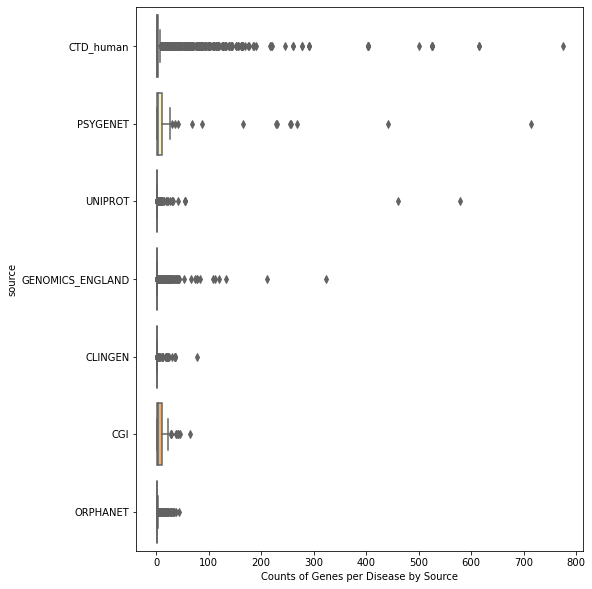

In [5]:
#Boxplot of Counts of Genes per Disease for each Source:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Counts of Genes per Disease by Source',
                 data = logSumDisease, palette="Set3", orient = 'h')

Plotting the count of genes for each disease per source, we can see that there are extremely small gene sets, many containing only one gene per disease, in 5 of the 7 sources, which isn’t very useful for our machine learning model.

<AxesSubplot:xlabel='Log of Counts of Genes per Disease by Source', ylabel='source'>

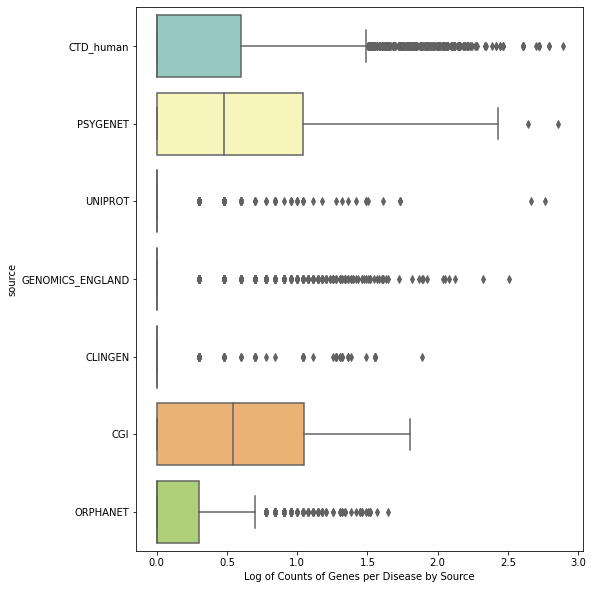

In [6]:
#Boxplot of Log of Counts of Genes per Disease for each Source:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Log of Counts of Genes per Disease by Source',
                 data = logSumDisease, palette="Set3", orient = 'h')

In [7]:
# Dataset with Fraction of Genes for a Disease per Source:
logSumDisease2 = threeColsep.groupby(by = ['diseaseId']).size().sort_values(ascending=False).reset_index(name = 'Counts of Diseases')
result = logSumDisease.merge(logSumDisease2)
result['Ratio'] = result['Counts of Genes per Disease by Source']/result['Counts of Diseases']
result

,diseaseId,source,Counts of Genes per Disease by Source,Log of Counts of Genes per Disease by Source,Counts of Diseases,Ratio
0,C0023893,CTD_human,774,2.888741,774,1.000000
1,C0036341,PSYGENET,713,2.853090,887,0.803833
2,C0036341,CTD_human,170,2.230449,887,0.191657
3,C0036341,GENOMICS_ENGLAND,3,0.477121,887,0.003382
4,C0036341,UNIPROT,1,0.000000,887,0.001127
...,...,...,...,...,...,...
22240,C1844830,GENOMICS_ENGLAND,1,0.000000,3,0.333333
22241,C1844830,UNIPROT,1,0.000000,3,0.333333
22242,C1844836,ORPHANET,1,0.000000,1,1.000000
22243,C1844853,GENOMICS_ENGLAND,1,0.000000,2,0.500000


<AxesSubplot:xlabel='Ratio', ylabel='source'>

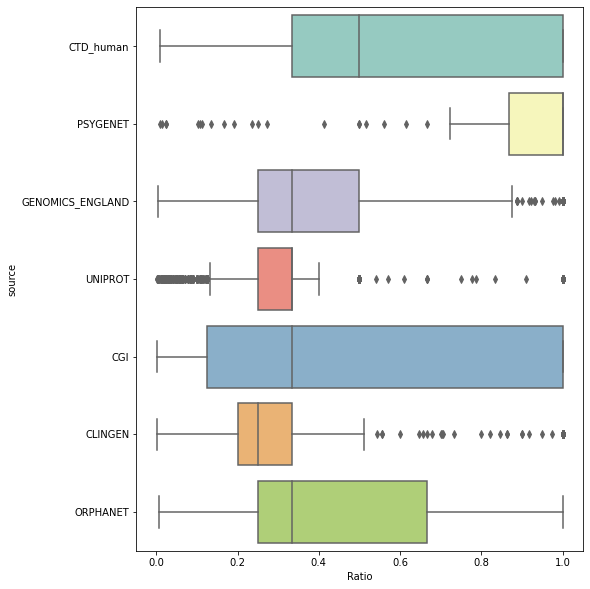

In [8]:
#Boxplot of Fraction of Genes for a Disease per Source:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Ratio',
                 data = result, palette="Set3", orient = 'h')

The genes for each disease divided by the total number of genes for each association type. CTD_human has the largest median/fraction. CGI envompasses a large portion of the data

## Gene Comparison and Exploration:

In [9]:
# Creating Gene Sets for Each Source Based on Disease:
a = threeColsep.groupby(by = ['diseaseId', 'source'])['geneId'].apply(lambda x: set(x))
a = a.reset_index()

# Creating Sets of Sources Based on Disease
a2 = a.groupby(by = ['diseaseId'])['source'].apply(lambda x: set(x))
a2 = a2.to_frame().reset_index()

# Creating the Different Possible Combinations of Sources for Each Disease:
from itertools import permutations
a2['permutations'] = a2['source'].apply(lambda r: list(permutations(r, 2)))

# Removing the Diseases that Only Hold One Source:
a3 = a2[a2['permutations'].map(lambda d: len(d)) > 0]

# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.diseaseId) for tup in a3.itertuples() for c in tup.permutations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'diseaseId'})

# Separating the Created Combinations into 2 Columns:
resultGE[['source1','source2']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)
resultGE

,Combos,diseaseId,source1,source2
0,"(CTD_human, GENOMICS_ENGLAND)",C0000744,CTD_human,GENOMICS_ENGLAND
1,"(CTD_human, ORPHANET)",C0000744,CTD_human,ORPHANET
2,"(CTD_human, UNIPROT)",C0000744,CTD_human,UNIPROT
3,"(GENOMICS_ENGLAND, CTD_human)",C0000744,GENOMICS_ENGLAND,CTD_human
4,"(GENOMICS_ENGLAND, ORPHANET)",C0000744,GENOMICS_ENGLAND,ORPHANET
...,...,...,...,...
36079,"(UNIPROT, GENOMICS_ENGLAND)",C4749023,UNIPROT,GENOMICS_ENGLAND
36080,"(GENOMICS_ENGLAND, UNIPROT)",C4749028,GENOMICS_ENGLAND,UNIPROT
36081,"(UNIPROT, GENOMICS_ENGLAND)",C4749028,UNIPROT,GENOMICS_ENGLAND
36082,"(GENOMICS_ENGLAND, ORPHANET)",C4751204,GENOMICS_ENGLAND,ORPHANET


In [10]:
#Finding the gene sets associated to each gene-disease pair source
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = a.loc[(a['diseaseId'] == row['diseaseId']) & (a['source'] == row['source1'])]
    arowList.append(midrow.iloc[0]['geneId'])
    
    midrow2 = a.loc[(a['diseaseId'] == row['diseaseId']) & (a['source'] == row['source2'])]
    arow2List.append(midrow2.iloc[0]['geneId'])

In [11]:
#Adding the gene sets back into the dataset
resultGE['geneId1'] = arowList
resultGE['geneId2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan

In [12]:
# Jaccard Similarity Coefficient/Jaccard Index Function:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [13]:
#Helper function for Jaccard Index
def f(x):
    return jaccard(x['geneId1'], x['geneId2']) 

In [14]:
#Obtaining Jaccard Similarity Coefficient Between Gene Sets for each Row
resultGE['jaccardIndex'] = resultGE.apply(f, axis = 1)
resultGE

,diseaseId,source1,source2,geneId1,geneId2,jaccardIndex
0,C0000744,CTD_human,GENOMICS_ENGLAND,{4547},{4547},1.0
1,C0000744,CTD_human,ORPHANET,{4547},{4547},1.0
2,C0000744,CTD_human,UNIPROT,{4547},{4547},1.0
3,C0000744,GENOMICS_ENGLAND,CTD_human,{4547},{4547},1.0
4,C0000744,GENOMICS_ENGLAND,ORPHANET,{4547},{4547},1.0
...,...,...,...,...,...,...
36079,C4749023,UNIPROT,GENOMICS_ENGLAND,{221692},{221692},1.0
36080,C4749028,GENOMICS_ENGLAND,UNIPROT,{1770},{1770},1.0
36081,C4749028,UNIPROT,GENOMICS_ENGLAND,{1770},{1770},1.0
36082,C4751204,GENOMICS_ENGLAND,ORPHANET,{1581},{1581},1.0


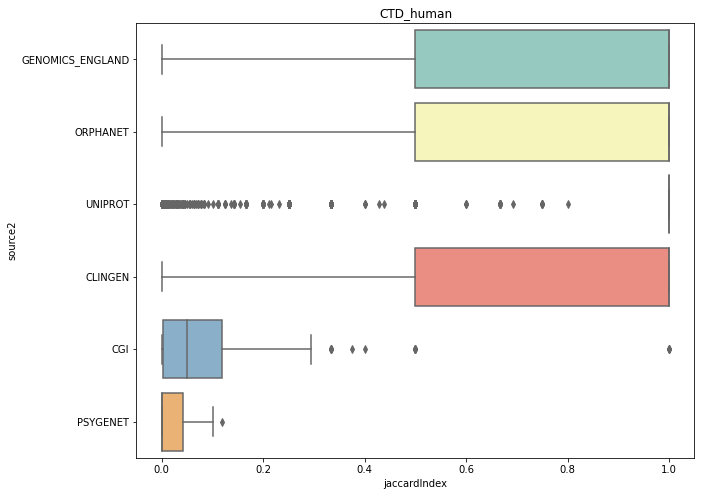

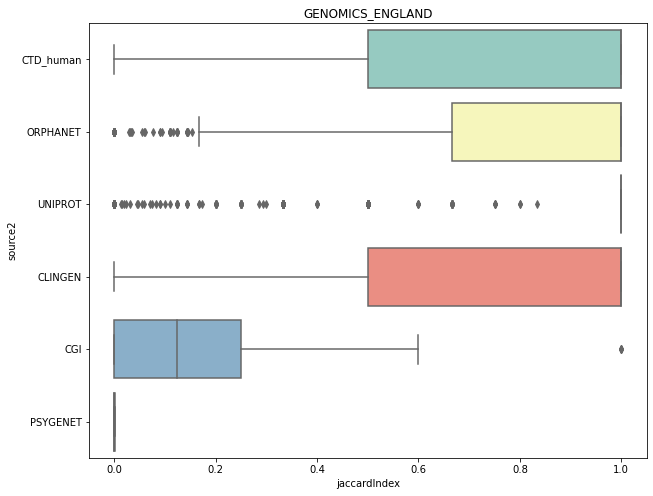

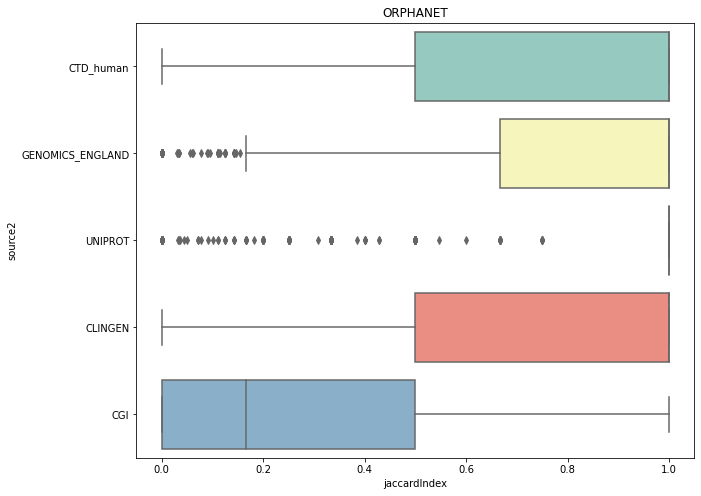

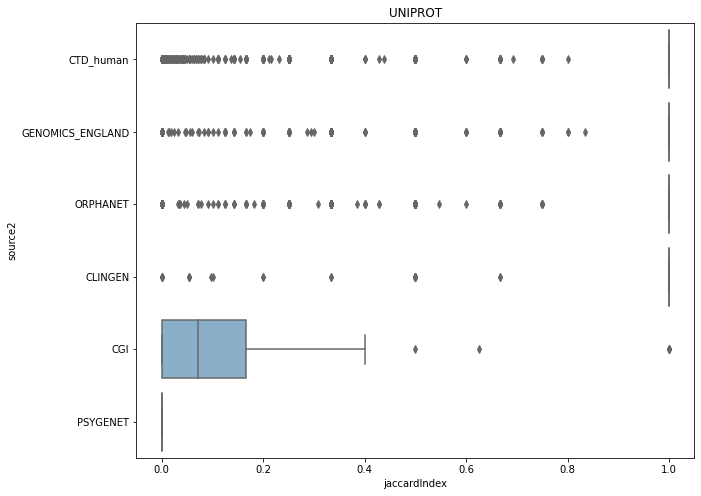

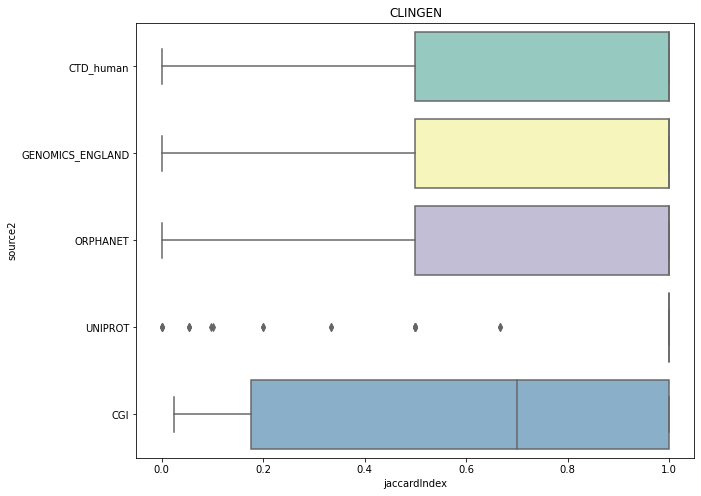

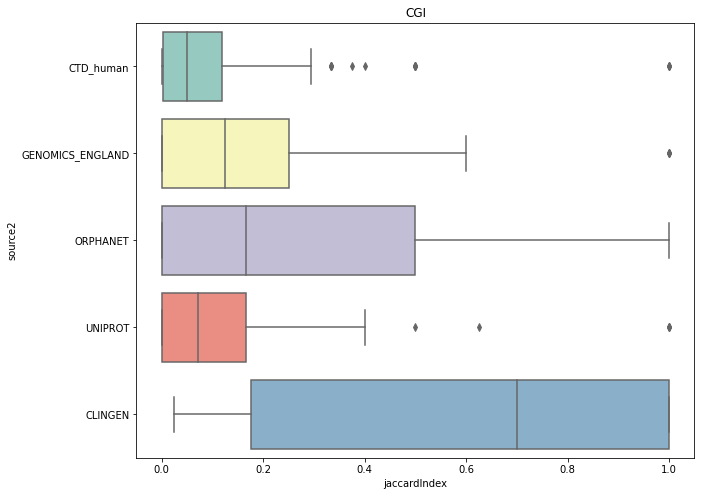

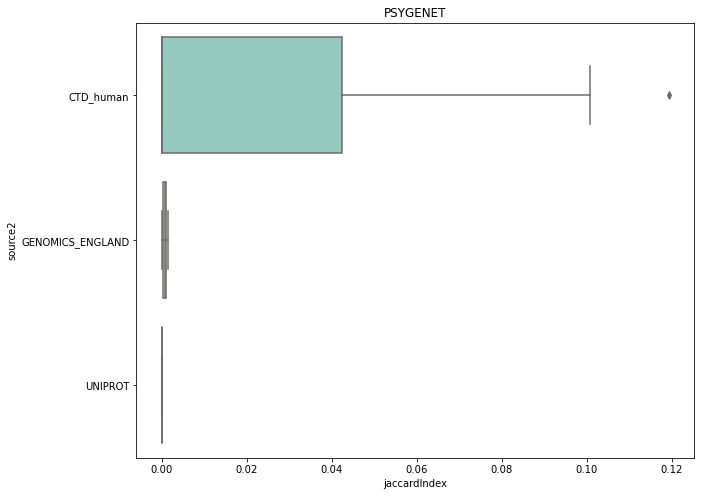

In [15]:
#Boxplots for Gene Exploration
for i, source in enumerate(resultGE.source1.unique(), 1): #Iterating through each unique Source
    data = resultGE[resultGE.source1 == source] #Filtering by Source
    fig, ax = plt.subplots(figsize = (10,8))
    sns.boxplot(x = 'jaccardIndex', y = 'source2',
                 data = data, palette="Set3", orient = 'h')
    plt.title(source)

The Boxplots comparing gene sets from one source to every other source are shown above. We can see the median Jaccard coefficient for many of these source pairings is 1, suggesting that a lot of the gene sets for the source type pairs only have one gene in them, which makes it much more likely for the sets to be correlated perfectly. Thus, we need to filter the data to meet certain conditions, like a minimum gene set size, to obtain a curated dataset with more workable data. Also, while not completely relevant, we can see that those sources in the CTD_human plot that do not have a median correlation of 1 are the two with the smallest disease and gene counts. The PSYGENET plot is so baren for this reason as well. It only has a median correlation of 1 with itself.

In [16]:
# Reorganizing the Dataset to Obtain the Median Values for Each Source Combination:
# This new dataset will have one row for each source combination, a set of the jaccard Indices for that source combination, and a median of the values for each of those sets. 
# Those median values are what will be placed in the heatmap!
resultGE2 = resultGE.drop(columns = ['diseaseId', 'geneId1', 'geneId2'])
resultGE2 = resultGE2.groupby(by = ['source1', 'source2'])['jaccardIndex'].apply(lambda x: list(x))
resultGE2 = resultGE2.reset_index()

In [17]:
#Adding the median of the Jaccard Sets for source combos to a separate column
jaccardsets = resultGE2['jaccardIndex']
medians = []
for aset in jaccardsets:
    medians.append(statistics.median(aset))
resultGE2['Median'] = medians
resultGE2

,source1,source2,jaccardIndex,Median
0,CGI,CLINGEN,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000
1,CGI,CTD_human,"[0.4, 0.0, 0.05, 0.05, 0.02631578947368421, 0....",0.048810
2,CGI,GENOMICS_ENGLAND,"[0.3333333333333333, 0.17391304347826086, 0.0,...",0.125000
3,CGI,ORPHANET,"[0.5, 0.043478260869565216, 1.0, 0.08695652173...",0.166667
4,CGI,UNIPROT,"[0.0, 0.058823529411764705, 0.0625, 0.0, 0.021...",0.071429
5,CLINGEN,CGI,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000
6,CLINGEN,CTD_human,"[1.0, 1.0, 1.0, 0.0, 0.4, 0.6666666666666666, ...",1.000000
7,CLINGEN,GENOMICS_ENGLAND,"[1.0, 1.0, 1.0, 0.10526315789473684, 0.6666666...",1.000000
8,CLINGEN,ORPHANET,"[1.0, 0.6666666666666666, 0.6666666666666666, ...",1.000000
9,CLINGEN,UNIPROT,"[1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, ...",1.000000


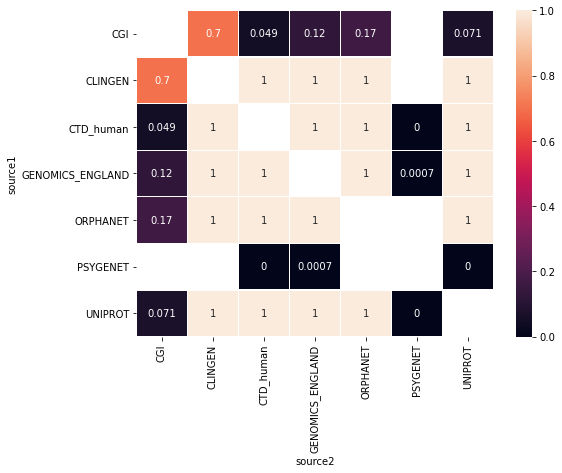

In [18]:
#Heatmap with Curated Dataset Median Jaccard Index:
resultGE3 = resultGE2.pivot("source1", "source2", "Median")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE3, annot = True, linewidths = .25)

In this heatmap of the Median Jaccard Simmilarity Coefficients, we can see most correlations are 1, suggesting that a lot of the gene sets for the source type pairs only have one gene in them, which makes it much more likely for the sets to be correlated perfectly. Thus, we need to filter the data to meet certain conditions, like a minimum gene set size, to obtain a curated dataset with more workable data. We also see some blanks in the heatmap between PSYGENET and CGI, CLINGEN, and ORPHANET, which we can expect. As we said, there is only a very small amount of data from PSYGENET in this dataset, so it is very likely for us to see no possible correlations between that source and others. Especially since CGI and CLINGEN are the next two smallest in size. 

In [19]:
#Adding the mean of the Jaccard Sets for source combos to a separate column to show the effect of outliers
meansets = resultGE2['jaccardIndex']
means = []
for aset in meansets:
    means.append(statistics.mean(aset))
resultGE2['Mean'] = means
resultGE2

,source1,source2,jaccardIndex,Median,Mean
0,CGI,CLINGEN,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000,0.587302
1,CGI,CTD_human,"[0.4, 0.0, 0.05, 0.05, 0.02631578947368421, 0....",0.048810,0.123378
2,CGI,GENOMICS_ENGLAND,"[0.3333333333333333, 0.17391304347826086, 0.0,...",0.125000,0.205939
3,CGI,ORPHANET,"[0.5, 0.043478260869565216, 1.0, 0.08695652173...",0.166667,0.307413
4,CGI,UNIPROT,"[0.0, 0.058823529411764705, 0.0625, 0.0, 0.021...",0.071429,0.155051
5,CLINGEN,CGI,"[0.023809523809523808, 0.1, 1.0, 0.4, 1.0, 1.0]",0.700000,0.587302
6,CLINGEN,CTD_human,"[1.0, 1.0, 1.0, 0.0, 0.4, 0.6666666666666666, ...",1.000000,0.738413
7,CLINGEN,GENOMICS_ENGLAND,"[1.0, 1.0, 1.0, 0.10526315789473684, 0.6666666...",1.000000,0.802304
8,CLINGEN,ORPHANET,"[1.0, 0.6666666666666666, 0.6666666666666666, ...",1.000000,0.757499
9,CLINGEN,UNIPROT,"[1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, ...",1.000000,0.934761


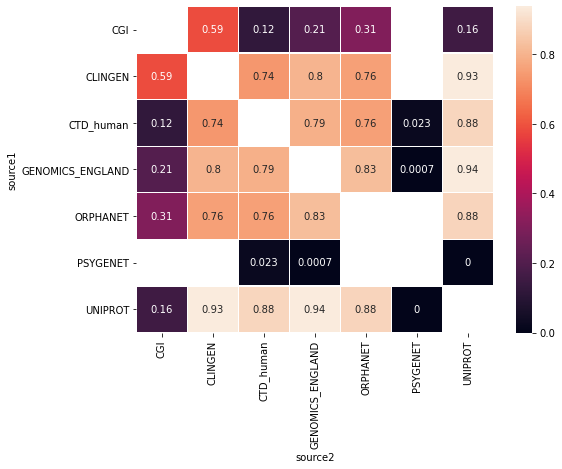

In [20]:
#Heatmap with Curated Dataset Mean Jaccard Index:
resultGE4 = resultGE2.pivot("source1", "source2", "Mean")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE4, annot = True, linewidths = .25)

Creating the same heatmap with the mean Jaccard Index helps to show how outliers actually bring down the correlations between sources (because it is an abnormality if the disease has more than one gene in its gene set, which then leads to lower correlation scores for these outlier cases)

In [21]:
#Combined Dataset (if needed):
diseaseinfo = pd.read_csv('DisGeNETFiles/diseaseAttributes.tsv', sep = "\t")
geneinfo = pd.read_csv('DisGeNETFiles/geneAttributes.tsv', sep = "\t")
geneinfo = geneinfo.drop(columns = ['pLI', 'DSI', 'DPI'])
result1 = threeColsep.merge(diseaseinfo)
result2 = result1.merge(geneinfo)
dfOG = pd.read_csv('DisGeNETFiles/geneDiseaseNetwork.tsv', sep = "\t")
combined = result2.merge(dfOG)
combined = combined[['NID', 'diseaseNID', 'diseaseId', 'diseaseName', 'geneNID', 'geneId', 'geneName', 'associationType', 'source']]
combined

/mnt/home/f0102402/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,NID,diseaseNID,diseaseId,diseaseName,geneNID,geneId,geneName,associationType,source
0,770711,1371,C0019209,Hepatomegaly,1,1,A1BG,Biomarker,CTD_human
1,1453814,2733,C0036341,Schizophrenia,1,1,A1BG,Biomarker,CTD_human
2,770798,1371,C0019209,Hepatomegaly,144,196,AHR,Biomarker,CTD_human
3,770799,1371,C0019209,Hepatomegaly,144,196,AHR,Therapeutic,CTD_human
4,770800,1371,C0019209,Hepatomegaly,144,196,AHR,Biomarker,CTD_human
...,...,...,...,...,...,...,...,...,...
151272,2910614,18944,C1863843,Neuronal intranuclear inclusion disease,21542,100996717,NOTCH2NLC,GermlineCausalMutation,ORPHANET
151273,3122966,24241,C3888401,"ALBINISM, OCULOCUTANEOUS, TYPE V",21604,101926885,OCA5,Biomarker,GENOMICS_ENGLAND
151274,3154549,27279,C4085249,OPTIC ATROPHY 8,25057,106783499,OPA8,Biomarker,GENOMICS_ENGLAND
151275,2411347,11159,C0730294,North Carolina macular dystrophy,25078,107305681,DHS6S1,Biomarker,CTD_human


## Separate Heatmap of Curated Dataset with Both Association Types and Sources:

In [23]:
#Creating a subset of the original curated dataset that can be appended to the dataset that includes the association types
result1 = threeColsep.merge(diseaseinfo)
result2 = result1.merge(geneinfo)
result2 = result2[['diseaseNID', 'geneNID', 'source']]
result2 = result2.rename(columns = {'source': 'propAssociationType/source'})
result2

,diseaseNID,geneNID,propAssociationType/source
0,1371,1,CTD_human
1,2733,1,CTD_human
2,1371,144,CTD_human
3,1796,144,CTD_human
4,5405,144,CTD_human
...,...,...,...
96920,18944,21542,ORPHANET
96921,24241,21604,GENOMICS_ENGLAND
96922,27279,25057,GENOMICS_ENGLAND
96923,11159,25078,CTD_human


In [25]:
#Reading in the Propagated Recategorized unique Biomarker dataset with the 5 association types, which will be appended to the dataset above
relabeled = pd.read_csv('OutputFiles/relabeledDataset.csv')
relabeled = relabeled.drop(columns = ['ogAssociationTypes'])
relabeled = relabeled.rename(columns={'propagatedAssociationType': 'propAssociationType/source'})
relabeled

,diseaseNID,geneNID,propAssociationType/source
0,1317,1088,AlteredExpression
1,1338,1088,AlteredExpression
2,1741,1088,AlteredExpression
3,2107,1088,PosttranslationalModification
4,2592,1088,AlteredExpression
...,...,...,...
1202259,29239,20075,Biomarker
1202260,29280,20163,Biomarker
1202261,29341,20169,Biomarker
1202262,29763,9527,Biomarker


In [26]:
#Appending the two datasets together
sourceAndAssoc = relabeled.append(result2)
sourceAndAssoc

,diseaseNID,geneNID,propAssociationType/source
0,1317,1088,AlteredExpression
1,1338,1088,AlteredExpression
2,1741,1088,AlteredExpression
3,2107,1088,PosttranslationalModification
4,2592,1088,AlteredExpression
...,...,...,...
96920,18944,21542,ORPHANET
96921,24241,21604,GENOMICS_ENGLAND
96922,27279,25057,GENOMICS_ENGLAND
96923,11159,25078,CTD_human


In [27]:
# Creating Gene Sets Again for Each Source/Association Type Based on Disease, but using this appended dataset:
a = sourceAndAssoc.groupby(by = ['diseaseNID', 'propAssociationType/source'])['geneNID'].apply(lambda x: set(x))
a = a.reset_index()

# Creating Sets of Sources/Association Types Based on Disease:
a2 = a.groupby(by = ['diseaseNID'])['propAssociationType/source'].apply(lambda x: set(x))
a2 = a2.to_frame().reset_index()

# Creating the Different Possible Combinations of Sources/Association Types for Each Disease:
a2['permutations'] = a2['propAssociationType/source'].apply(lambda r: list(permutations(r, 2)))

# Removing the Diseases that Only Hold One Source/Association Type:
a3 = a2[a2['permutations'].map(lambda d: len(d)) > 0]

# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.diseaseNID) for tup in a3.itertuples() for c in tup.permutations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'diseaseNID'})

# Separating the Created Combinations into 2 Columns:
resultGE[['assocSource1','assocSource2']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)
resultGE

,Combos,diseaseNID,assocSource1,assocSource2
0,"(Biomarker, GenomicAlterations)",3,Biomarker,GenomicAlterations
1,"(GenomicAlterations, Biomarker)",3,GenomicAlterations,Biomarker
2,"(AlteredExpression, Biomarker)",5,AlteredExpression,Biomarker
3,"(AlteredExpression, GenomicAlterations)",5,AlteredExpression,GenomicAlterations
4,"(Biomarker, AlteredExpression)",5,Biomarker,AlteredExpression
...,...,...,...,...
197207,"(AlteredExpression, GenomicAlterations)",30292,AlteredExpression,GenomicAlterations
197208,"(Biomarker, AlteredExpression)",30292,Biomarker,AlteredExpression
197209,"(Biomarker, GenomicAlterations)",30292,Biomarker,GenomicAlterations
197210,"(GenomicAlterations, AlteredExpression)",30292,GenomicAlterations,AlteredExpression


In [28]:
#Finding the gene sets associated to each gene-disease pair source/association type 
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['propAssociationType/source'] == row['assocSource1'])]
    arowList.append(midrow.iloc[0]['geneNID'])
    
    midrow2 = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['propAssociationType/source'] == row['assocSource2'])]
    arow2List.append(midrow2.iloc[0]['geneNID'])

In [29]:
#Adding the gene sets back into the dataset
resultGE['geneNID1'] = arowList
resultGE['geneNID2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan

In [32]:
def g(x):
    return jaccard(x['geneNID1'], x['geneNID2']) 

In [33]:
#Obtaining Jaccard Similarity Coefficient Between Gene Sets for each Row
resultGE['jaccardIndex'] = resultGE.apply(g, axis = 1)
resultGE

,diseaseNID,assocSource1,assocSource2,geneNID1,geneNID2,jaccardIndex
0,3,Biomarker,GenomicAlterations,"{522, 525, 7694, 5650, 5139, 11283, 12826, 156...","{4711, 6417, 5458, 1813, 3065, 17182}",0.0
1,3,GenomicAlterations,Biomarker,"{4711, 6417, 5458, 1813, 3065, 17182}","{522, 525, 7694, 5650, 5139, 11283, 12826, 156...",0.0
2,5,AlteredExpression,Biomarker,"{3288, 1924}","{129, 4577, 3559, 11754, 1489, 3799, 1567}",0.0
3,5,AlteredExpression,GenomicAlterations,"{3288, 1924}","{5304, 5241, 8699, 2126}",0.0
4,5,Biomarker,AlteredExpression,"{129, 4577, 3559, 11754, 1489, 3799, 1567}","{3288, 1924}",0.0
...,...,...,...,...,...,...
197207,30292,AlteredExpression,GenomicAlterations,"{3833, 11963, 2493, 270}","{2403, 1738, 9805, 270, 6738, 3829, 4057}",0.1
197208,30292,Biomarker,AlteredExpression,"{18471, 46, 19792, 632, 1115, 1436, 2111, 3551}","{3833, 11963, 2493, 270}",0.0
197209,30292,Biomarker,GenomicAlterations,"{18471, 46, 19792, 632, 1115, 1436, 2111, 3551}","{2403, 1738, 9805, 270, 6738, 3829, 4057}",0.0
197210,30292,GenomicAlterations,AlteredExpression,"{2403, 1738, 9805, 270, 6738, 3829, 4057}","{3833, 11963, 2493, 270}",0.1


In [34]:
# Reorganizing the Dataset to Obtain the Median Values for Each Source/Association Type Combination:
# This new dataset will have one row for each source/association type combination, a set of the jaccard Indices for that source/association type combination, and a median of the values for each of those sets. 
#Those median values are what will be placed in the heatmap
resultGE2 = resultGE.drop(columns = ['diseaseNID', 'geneNID1', 'geneNID2'])
resultGE2 = resultGE2.groupby(by = ['assocSource1', 'assocSource2'])['jaccardIndex'].apply(lambda x: list(x))
resultGE2 = resultGE2.reset_index()

In [35]:
#Adding the median of the Jaccard Sets for source/association type combos to a separate column
jaccardsets = resultGE2['jaccardIndex']
medians = []
for aset in jaccardsets:
    medians.append(statistics.median(aset))
resultGE2['Median'] = medians
resultGE2

,assocSource1,assocSource2,jaccardIndex,Median
0,AlteredExpression,Biomarker,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
1,AlteredExpression,CGI,"[0.0, 0.01834862385321101, 0.0, 0.008264462809...",0.007692
2,AlteredExpression,CLINGEN,"[0.1111111111111111, 0.16666666666666666, 0.04...",0.066667
3,AlteredExpression,CTD_human,"[0.0, 0.07692307692307693, 0.02877697841726619...",0.014286
4,AlteredExpression,GENOMICS_ENGLAND,"[0.07692307692307693, 0.1111111111111111, 0.0,...",0.004619
...,...,...,...,...
121,UNIPROT,GenomicAlterations,"[0.04, 0.05263157894736842, 0.1, 1.0, 0.002435...",1.000000
122,UNIPROT,ORPHANET,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.3333333333333333, ...",1.000000
123,UNIPROT,PSYGENET,[0.0],0.000000
124,UNIPROT,PosttranslationalModification,"[0.018518518518518517, 0.0, 0.0, 0.0, 0.1, 0.0...",0.000000


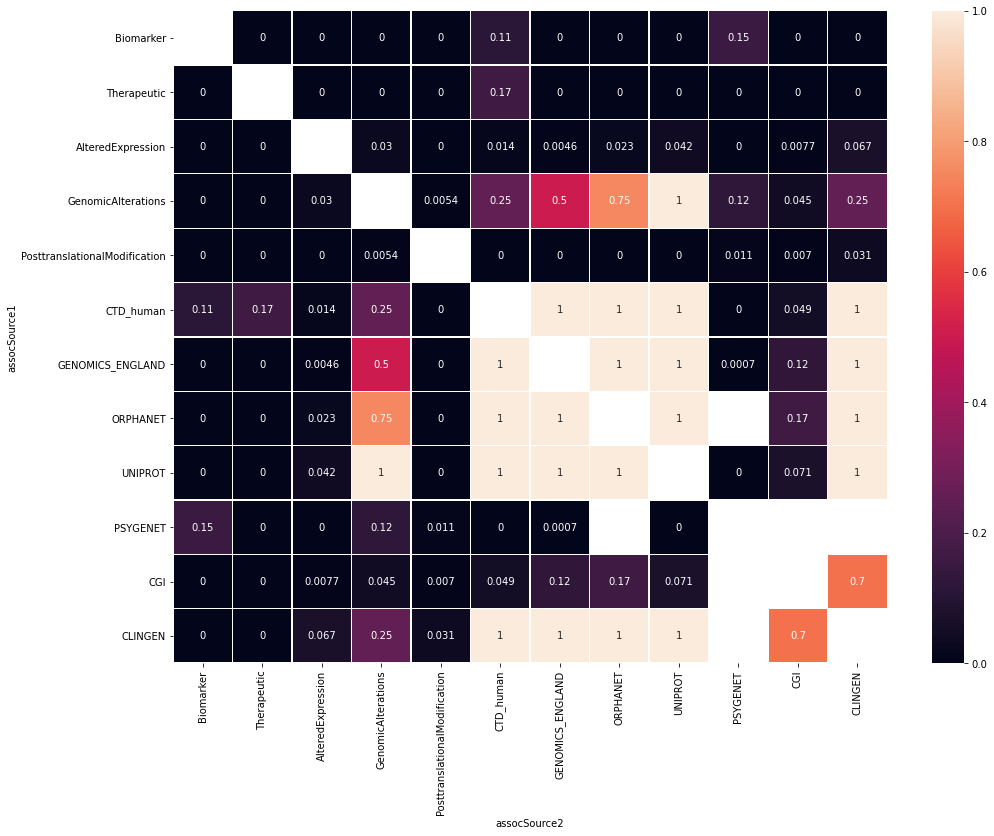

In [36]:
#Pivoting the dataset to create the heatmap
resultGE3 = resultGE2.pivot("assocSource1", "assocSource2", "Median")

#Reorganizing the dataset so that sources are grouped next to each other and association types are grouped next to each other
resultGE3.index = pd.CategoricalIndex(resultGE3.index, categories= ['Biomarker', 'Therapeutic', 'AlteredExpression', 'GenomicAlterations', 'PosttranslationalModification', 'CTD_human', 'GENOMICS_ENGLAND', 'ORPHANET', 'UNIPROT', 'PSYGENET', 'CGI', 'CLINGEN'])
resultGE3.sort_index(level=0, inplace=True)
resultGE3 = resultGE3[['Biomarker', 'Therapeutic', 'AlteredExpression', 'GenomicAlterations', 'PosttranslationalModification', 'CTD_human', 'GENOMICS_ENGLAND', 'ORPHANET', 'UNIPROT', 'PSYGENET', 'CGI', 'CLINGEN']]

#Heatmap of Median Jaccard Indicies Between Source/Association Type Combinations
fig, ax = plt.subplots(figsize=(16,12))   
ax = sns.heatmap(resultGE3, annot = True, linewidths = .25)

# Curated Dataset Filtering for Disease Selection for Supervised Machine Learning Model:

In [37]:
#Using the diseasemappings file from DisGeNET to get DOID formatted diseases
diseasemappings = pd.read_csv('DisGeNETFiles/disease_mappings.tsv', sep = '\t')
diseasemappings = diseasemappings.drop(columns = ['vocabularyName'])
diseasemappings = diseasemappings.rename(columns = {'name': 'diseaseName'})
#Only keeping disease-gene pairs with DO as the vocabulary name
diseasemappings = diseasemappings[diseasemappings['vocabulary'].map(lambda d: d == 'DO')]
diseasemappings

,diseaseId,diseaseName,vocabulary,code
0,C0018923,Hemangiosarcoma,DO,0001816
1,C0854893,Angiosarcoma non-metastatic,DO,0001816
2,C0033999,Pterygium,DO,0002116
3,C0025517,Metabolic Diseases,DO,0014667
4,C0155862,Streptococcal pneumonia,DO,0040084
...,...,...,...,...
13631,C0272192,Familial eosinophilia,DO,999
13632,C0014457,Eosinophilia,DO,999
13633,C0311368,Idiopathic eosinophilia,DO,999
13634,C0020615,Hypoglycemia,DO,9993


In [38]:
#Merging diseasemappings with curated dataset to help get the diseases into DOID format:
result2 = diseasemappings.merge(threeColsep)
#result2 = result1[result1['vocabulary'].map(lambda d: d == 'DO')]
result2['DOID'] = ('DOID:' + (result2['code']))
result2

,diseaseId,diseaseName,vocabulary,code,source,geneId,geneSymbol,DOID
0,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,285,ANGPT2,DOID:0001816
1,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,595,CCND1,DOID:0001816
2,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1440,CSF3,DOID:0001816
3,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,1499,CTNNB1,DOID:0001816
4,C0018923,Hemangiosarcoma,DO,0001816,CTD_human,2321,FLT1,DOID:0001816
...,...,...,...,...,...,...,...,...
99446,C0020615,Hypoglycemia,DO,9993,CTD_human,5465,PPARA,DOID:9993
99447,C0020615,Hypoglycemia,DO,9993,CTD_human,6648,SOD2,DOID:9993
99448,C0020615,Hypoglycemia,DO,9993,CTD_human,6927,HNF1A,DOID:9993
99449,C0020615,Hypoglycemia,DO,9993,CTD_human,7124,TNF,DOID:9993


In [39]:
#Grouping the genes into gene sets:
resultDOID = result2.groupby(by = ['DOID', 'diseaseName', 'source'])['geneId'].apply(lambda x: set(x))
resultDOID = resultDOID.reset_index()
resultDOID

,DOID,diseaseName,source,geneId
0,DOID:0001816,Hemangiosarcoma,CGI,"{5335, 5787, 3845, 3791}"
1,DOID:0001816,Hemangiosarcoma,CTD_human,"{1440, 3265, 4609, 7010, 7424, 3845, 2701, 372..."
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
4,DOID:0014667,Metabolic Diseases,CTD_human,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [40]:
#Importing the Ontology Class and calling it disease_ontology
from ontology import Ontology
disease_ontology = Ontology()
disease_ontology.load("/mnt/research/compbio/krishnanlab/data/ontologies/doid.obo")

In [41]:
#Getting all descendants from our 14 higher level terms and adding them into one file called desired
cardio = disease_ontology.descendants('DOID:1287')
endo = disease_ontology.descendants('DOID:28')
gastro = disease_ontology.descendants('DOID:77')
hemat = disease_ontology.descendants('DOID:74')
immune = disease_ontology.descendants('DOID:2914')
integu = disease_ontology.descendants('DOID:16')
musc = disease_ontology.descendants('DOID:17')
nervous = disease_ontology.descendants('DOID:863')
reprod = disease_ontology.descendants('DOID:229')
respir = disease_ontology.descendants('DOID:1579')
thoracic = disease_ontology.descendants('DOID:0060118')
urinary = disease_ontology.descendants('DOID:18')
metabolism = disease_ontology.descendants('DOID:0014667')
mhealth = disease_ontology.descendants('DOID:150')

desired = set().union(cardio).union(endo).union(gastro).union(hemat).union(immune).union(integu).union(musc).union(nervous).union(reprod).union(respir).union(thoracic).union(urinary).union(metabolism).union(mhealth)

In [42]:
#Also adding in the 14 higher level terms themselves into desired
desired.add('DOID:1287')
desired.add('DOID:28')
desired.add('DOID:77')
desired.add('DOID:74')
desired.add('DOID:2914')
desired.add('DOID:16')
desired.add('DOID:17')
desired.add('DOID:863')
desired.add('DOID:229')
desired.add('DOID:1579')
desired.add('DOID:0060118')
desired.add('DOID:18')
desired.add('DOID:0014667')
desired.add('DOID:150')

In [43]:
#All diseases from resultDOID that fall in the 14 higher level terms 
#(please excuse the name I used, I was a bit lazy to change it for all subsequent code)
desired12 = resultDOID[resultDOID['DOID'].isin(desired)]
desired12

,DOID,diseaseName,source,geneId
2,DOID:0002116,Pterygium,CTD_human,{3440}
3,DOID:0002116,Pterygium,GENOMICS_ENGLAND,{23299}
4,DOID:0014667,Metabolic Diseases,CTD_human,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
5,DOID:0040084,Streptococcal pneumonia,CTD_human,"{1673, 23411, 10747, 3576, 5594, 5595}"
7,DOID:0040099,"Skin Diseases, Vascular",CTD_human,{2147}
...,...,...,...,...
20005,DOID:998,Eosinophilia-Myalgia Syndrome,CTD_human,"{3123, 3117}"
20006,DOID:999,Eosinophilia,CTD_human,"{2625, 81858, 4615, 5897, 3567, 7097, 7099}"
20007,DOID:999,Eosinophilia,GENOMICS_ENGLAND,{3572}
20008,DOID:9993,Hypoglycemia,CTD_human,"{3553, 775, 5465, 6648, 3630, 6927, 5265, 7124..."


In [44]:
#Temporarily removing the diseaseName column to make dictionaries easier
desired12short = desired12.drop(columns = 'diseaseName')
#Creating a dictionary where the keys are the seven sources, and the labels are the data available for those sources (DOID, geneNID) in a dataset format 
dict_of_sources = dict(iter(desired12short.groupby('source')))

In [45]:
#Creaing a separate dictionary for each source
CLINGEN_dict = dict(zip(dict_of_sources['CLINGEN'].DOID, dict_of_sources['CLINGEN'].geneId))
CTD_human_dict = dict(zip(dict_of_sources['CTD_human'].DOID, dict_of_sources['CTD_human'].geneId))
CGI_dict = dict(zip(dict_of_sources['CGI'].DOID, dict_of_sources['CGI'].geneId))
GENOMICS_ENGLAND_dict = dict(zip(dict_of_sources['GENOMICS_ENGLAND'].DOID, dict_of_sources['GENOMICS_ENGLAND'].geneId))
PSYGENET_dict = dict(zip(dict_of_sources['PSYGENET'].DOID, dict_of_sources['PSYGENET'].geneId))
UNIPROT_dict = dict(zip(dict_of_sources['UNIPROT'].DOID, dict_of_sources['UNIPROT'].geneId))
ORPHANET_dict = dict(zip(dict_of_sources['ORPHANET'].DOID, dict_of_sources['ORPHANET'].geneId))

In [46]:
#Creating a propagated dictionary for each source
CLINGEN_prop = disease_ontology.propagate(CLINGEN_dict)
CTD_human_prop = disease_ontology.propagate(CTD_human_dict)
CGI_prop = disease_ontology.propagate(CGI_dict)
GENOMICS_ENGLAND_prop = disease_ontology.propagate(GENOMICS_ENGLAND_dict)
PSYGENET_prop = disease_ontology.propagate(PSYGENET_dict)
UNIPROT_prop = disease_ontology.propagate(UNIPROT_dict)
ORPHANET_prop = disease_ontology.propagate(ORPHANET_dict)

In [47]:
#Turning each dictionary into a dataframe
CLINGEN = pd.DataFrame([k for k in CLINGEN_prop.items()], columns=['DOID', 'geneSet'])
CTD_human = pd.DataFrame([k for k in CTD_human_prop.items()], columns=['DOID', 'geneSet'])
CGI = pd.DataFrame([k for k in CGI_prop.items()], columns=['DOID', 'geneSet'])
GENOMICS_ENGLAND = pd.DataFrame([k for k in GENOMICS_ENGLAND_prop.items()], columns=['DOID', 'geneSet'])
PSYGENET = pd.DataFrame([k for k in PSYGENET_prop.items()], columns=['DOID', 'geneSet'])
ORPHANET = pd.DataFrame([k for k in ORPHANET_prop.items()], columns=['DOID', 'geneSet'])
UNIPROT = pd.DataFrame([k for k in UNIPROT_prop.items()], columns=['DOID', 'geneSet'])

In [48]:
#Creating a column in each source dataset for the name of the dataset (so that this info will be available once the datasets are apended back together)
CLINGEN['source'] = 'CLINGEN'
CTD_human['source'] = 'CTD_human'
CGI['source'] = 'CGI'
GENOMICS_ENGLAND['source'] = 'GENOMICS_ENGLAND'
PSYGENET['source'] = 'PSYGENET'
ORPHANET['source'] = 'ORPHANET'
UNIPROT['source'] = 'UNIPROT'

In [49]:
#Appending the datasets back together
propagated = CLINGEN.append(CTD_human).append(CGI).append(GENOMICS_ENGLAND).append(PSYGENET).append(ORPHANET).append(UNIPROT)
propagated

,DOID,geneSet,source
0,DOID:0050332,"{2299, 3766}",CLINGEN
1,DOID:4,"{7168, 51204, 51206, 3081, 23568, 125972, 8399...",CLINGEN
2,DOID:2952,"{2299, 3766}",CLINGEN
3,DOID:2742,"{4641, 9381, 3766, 1687, 2299}",CLINGEN
4,DOID:3426,"{2299, 3766}",CLINGEN
...,...,...,...
2327,DOID:4079,{8642},UNIPROT
2328,DOID:61,{8642},UNIPROT
2329,DOID:9883,{1756},UNIPROT
2330,DOID:9955,{1482},UNIPROT


In [50]:
#Adding the disease name back into the dataset
templist = []
for index, row, in propagated.iterrows():
    templist.append(disease_ontology.nodes[row['DOID']]["name"])
propagated['diseaseName'] = templist
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:4,"{7168, 51204, 51206, 3081, 23568, 125972, 8399...",CLINGEN,disease
2,DOID:2952,"{2299, 3766}",CLINGEN,inner ear disease
3,DOID:2742,"{4641, 9381, 3766, 1687, 2299}",CLINGEN,auditory system disease
4,DOID:3426,"{2299, 3766}",CLINGEN,vestibular disease
...,...,...,...,...
2327,DOID:4079,{8642},UNIPROT,heart valve disease
2328,DOID:61,{8642},UNIPROT,mitral valve disease
2329,DOID:9883,{1756},UNIPROT,Becker muscular dystrophy
2330,DOID:9955,{1482},UNIPROT,hypoplastic left heart syndrome


### Writing to GMT files (for machine learning model labels):

In [51]:
#I need to turn this dataset (specifically the geneSet column) into a string instead of a set for Anna's method to run:
isinstance(propagated.iloc[0]['geneSet'], set)

True

In [52]:
#Anna's function to create gmt files
def write_gmt(filename, names, labels):
    with open(filename, "w") as f:
        for term in labels:
            f.write(
                "{}\t{}\t{}\n".format(
                    term, names[term], "\t".join(labels[term])
                )
            )

In [53]:
propagated['geneSet'] = (propagated['geneSet']).astype(str)
propagated['geneSet'] = propagated['geneSet'].apply(lambda x: set(x[1:-1].split(", ")))
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{3766, 2299}",CLINGEN,enlarged vestibular aqueduct
1,DOID:4,"{785, 5009, 84665, 1281, 6323, 5311, 55651, 27...",CLINGEN,disease
2,DOID:2952,"{3766, 2299}",CLINGEN,inner ear disease
3,DOID:2742,"{1687, 2299, 3766, 9381, 4641}",CLINGEN,auditory system disease
4,DOID:3426,"{3766, 2299}",CLINGEN,vestibular disease
...,...,...,...,...
2327,DOID:4079,{8642},UNIPROT,heart valve disease
2328,DOID:61,{8642},UNIPROT,mitral valve disease
2329,DOID:9883,{1756},UNIPROT,Becker muscular dystrophy
2330,DOID:9955,{1482},UNIPROT,hypoplastic left heart syndrome


In [54]:
propagated.iloc[0]['geneSet']

{'2299', '3766'}

In [56]:
#Creating a dictionary for each source (key), with the labels being DOID, geneSet, and diseaseName in a dataset format
sources_dict = dict(iter(propagated.groupby('source')))

In [57]:
for source in sources_dict:
    write_gmt(filename = ("OutputFiles/gmtFiles" + source + ".gmt"), names = (sources_dict[source].set_index('DOID').to_dict()['diseaseName']), 
              labels = (sources_dict[source].set_index('DOID').to_dict()['geneSet']))

In [58]:
#Recreating Boxplots (since we have filtered the dataset a little bit):

#Separating gene sets into separate rows, one for each gene-disease pair
dfsep = pd.DataFrame([(c, tup.DOID, tup.source) for tup in propagated.itertuples() for c in tup.geneSet])
dfsep = dfsep.rename(columns= {0: 'geneId', 1: 'propagatedDOID', 2: 'source'})
dfsep

,geneId,propagatedDOID,source
0,3766,DOID:0050332,CLINGEN
1,2299,DOID:0050332,CLINGEN
2,785,DOID:4,CLINGEN
3,5009,DOID:4,CLINGEN
4,84665,DOID:4,CLINGEN
...,...,...,...
188557,1756,DOID:9883,UNIPROT
188558,1482,DOID:9955,UNIPROT
188559,4160,DOID:9970,UNIPROT
188560,5468,DOID:9970,UNIPROT


In [62]:
#Dataset with Counts of Genes per Disease by Propagated Association Type (Log and non-log) for Boxplots
SumDisease = dfsep.groupby(by = ['propagatedDOID', 'source']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Source')
SumDisease['Log of Counts of Genes per Disease by Source'] = np.log10(SumDisease['Counts of Genes per Disease by Source'])
SumDisease

,propagatedDOID,source,Counts of Genes per Disease by Source,Log of Counts of Genes per Disease by Source
0,DOID:4,CTD_human,5739,3.758836
1,DOID:7,CTD_human,5041,3.702517
2,DOID:4,GENOMICS_ENGLAND,2449,3.388989
3,DOID:14566,CTD_human,2376,3.375846
4,DOID:0050686,CTD_human,2356,3.372175
...,...,...,...,...
11521,DOID:0110317,CTD_human,1,0.000000
11522,DOID:0110316,UNIPROT,1,0.000000
11523,DOID:0110316,GENOMICS_ENGLAND,1,0.000000
11524,DOID:0110316,CTD_human,1,0.000000


<AxesSubplot:xlabel='Counts of Genes per Disease by Source', ylabel='source'>

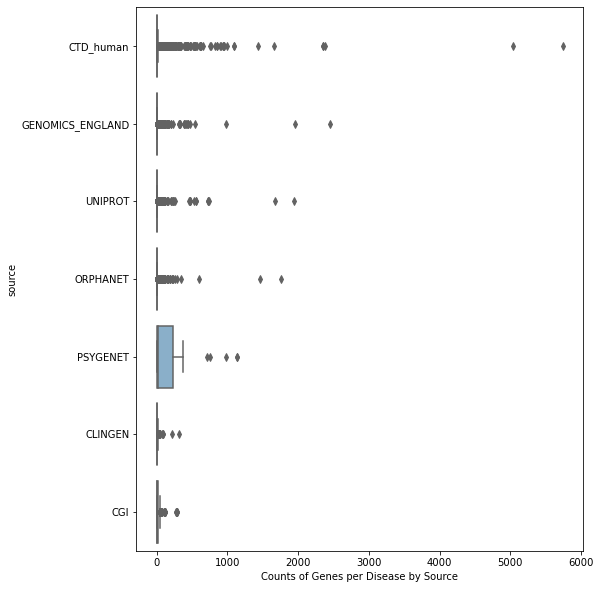

In [63]:
#Boxplot of Counts of Genes per Disease by Source
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Counts of Genes per Disease by Source',
                 data = SumDisease, palette="Set3", orient = 'h')

<AxesSubplot:xlabel='Log of Counts of Genes per Disease by Source', ylabel='source'>

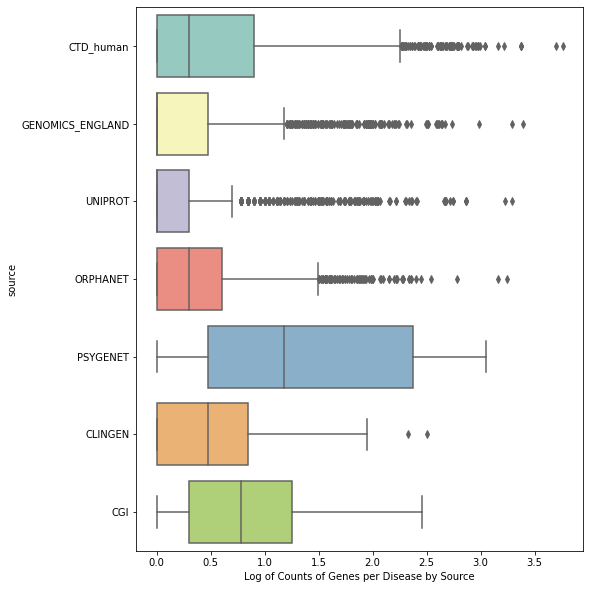

In [64]:
#Boxplot of Log of Counts of Genes per Disease by Source:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Log of Counts of Genes per Disease by Source',
                 data = SumDisease, palette="Set3", orient = 'h')

### Making Histograms:

Text(0, 0.5, 'Frequency')

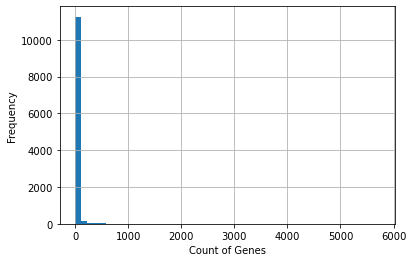

In [65]:
#Creating Histogram of Frequency of Gene Set Sizes for Propagated Curated Dataset:
SumDisease['Counts of Genes per Disease by Source'].hist(bins=50)
plt.xlabel("Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

After using a disease ontology to propagate the diseases (so that the ancestors of a disease would also be paired to that gene-disease association), we created some histograms to select decent boundaries. This one shows the counts of genes for all sources, and one can see there are an overwhelmingly large number of disease-source gene sets with small gene sets.

Text(0, 0.5, 'Frequency')

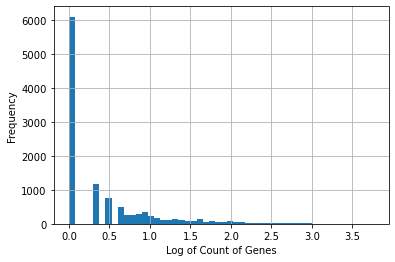

In [66]:
#Log Version of Histogram Above:
SumDisease['Log of Counts of Genes per Disease by Source'].hist(bins=50)
plt.xlabel("Log of Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

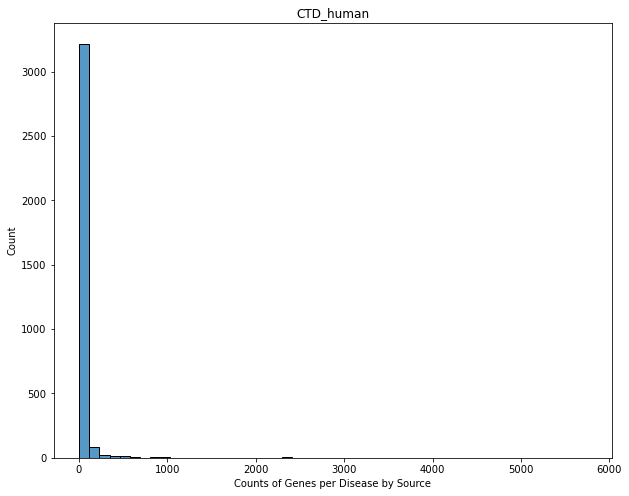

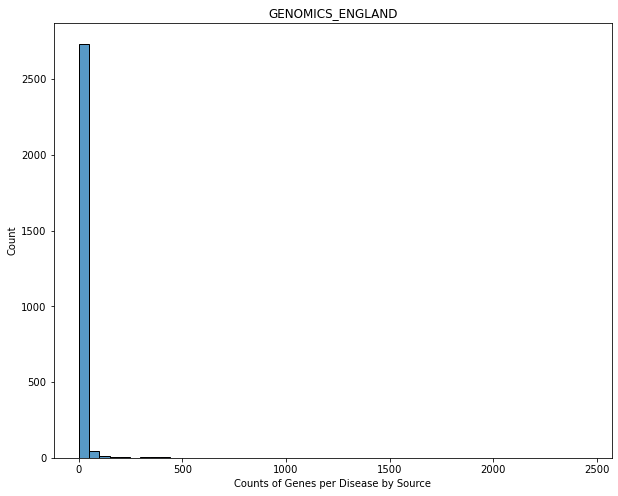

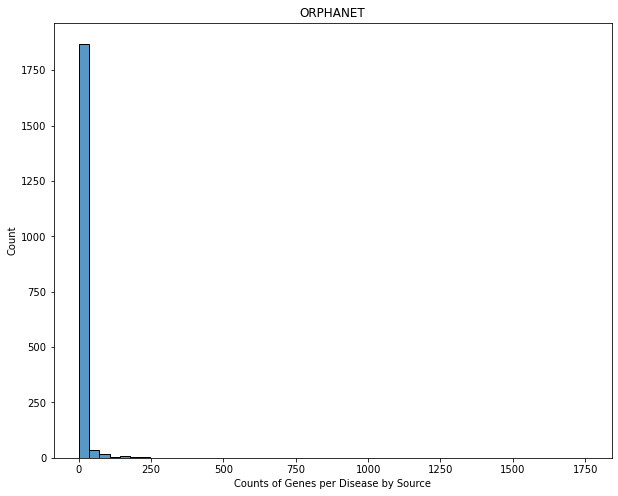

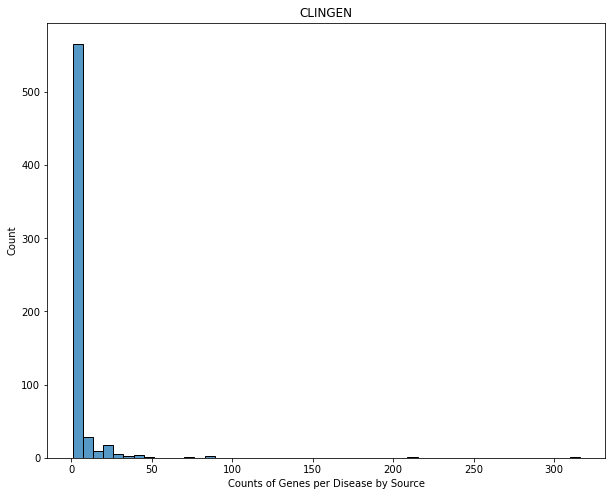

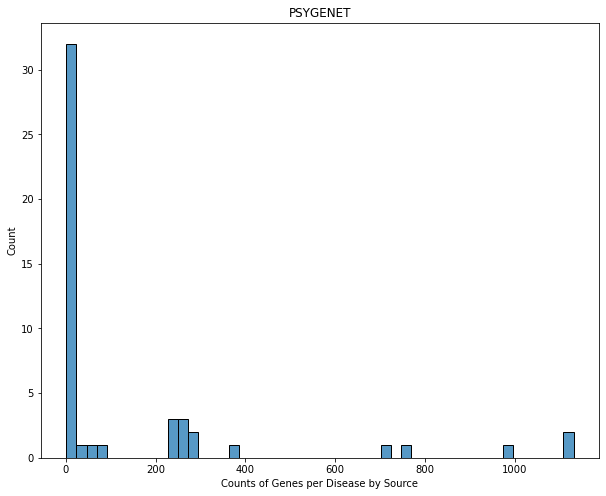

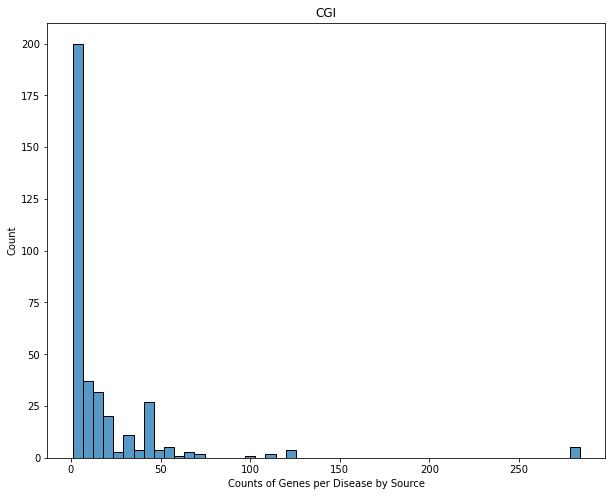

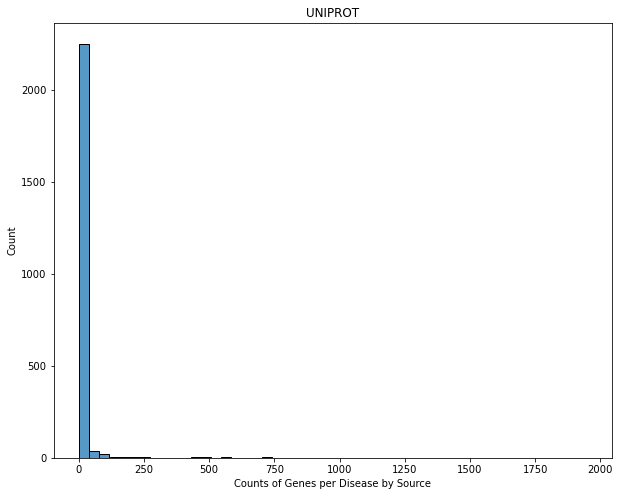

In [53]:
#Histograms broken down by source:
for i, source in enumerate(SumDisease.source.unique(), 1):
    data = SumDisease[SumDisease.source == source]
    fig, ax = plt.subplots(figsize = (10,8))
    sns.histplot(data['Counts of Genes per Disease by Source'], bins=50)
    plt.title(source)

### Finding out all the disease terms that have 10+ genes (after propagation) from 3 different sources:
This was done to make sure that we have the desired number of genes for multiple sources to draw conclusions from multiple sources (for interesting data)

In [67]:
#Grouping by Propagated Association Type and only keeping gene-disease pairs with 3 or more association types
propagatedafter = propagated.groupby(by = ['DOID', 'diseaseName'])['source'].apply(lambda x: set(x))
propagatedafter = propagatedafter.reset_index()

propagatedafter2 = propagatedafter[propagatedafter['source'].map(lambda d: len(d)) >= 3]
propagatedafter2

,DOID,diseaseName,source
1,DOID:0014667,disease of metabolism,"{CTD_human, CGI, CLINGEN, GENOMICS_ENGLAND, OR..."
4,DOID:0050013,carbohydrate metabolism disease,"{CTD_human, GENOMICS_ENGLAND, ORPHANET, UNIPROT}"
5,DOID:0050032,mineral metabolism disease,"{CTD_human, GENOMICS_ENGLAND, ORPHANET, UNIPROT}"
6,DOID:0050117,disease by infectious agent,"{CTD_human, GENOMICS_ENGLAND, ORPHANET, UNIPROT}"
7,DOID:0050120,hemophagocytic lymphohistiocytosis,"{CTD_human, GENOMICS_ENGLAND, ORPHANET, UNIPROT}"
...,...,...,...
3798,DOID:9884,muscular dystrophy,"{CTD_human, GENOMICS_ENGLAND, ORPHANET, UNIPROT}"
3802,DOID:9952,acute lymphocytic leukemia,"{CTD_human, CGI, GENOMICS_ENGLAND, UNIPROT}"
3803,DOID:9955,hypoplastic left heart syndrome,"{CTD_human, GENOMICS_ENGLAND, ORPHANET, UNIPROT}"
3805,DOID:9970,obesity,"{CTD_human, GENOMICS_ENGLAND, UNIPROT}"


In [68]:
#Splitting the sources back up
propagatedafter3 = pd.DataFrame([(c, tup.DOID, tup.diseaseName) for tup in propagatedafter2.itertuples() for c in tup.source])
propagatedafter3 = propagatedafter3.rename(columns= {0: 'source', 1: 'DOID', 2: 'diseaseName'})
propagatedafter3

,source,DOID,diseaseName
0,CTD_human,DOID:0014667,disease of metabolism
1,CGI,DOID:0014667,disease of metabolism
2,CLINGEN,DOID:0014667,disease of metabolism
3,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism
4,ORPHANET,DOID:0014667,disease of metabolism
...,...,...,...
9717,GENOMICS_ENGLAND,DOID:9970,obesity
9718,UNIPROT,DOID:9970,obesity
9719,CTD_human,DOID:999,hypereosinophilic syndrome
9720,CGI,DOID:999,hypereosinophilic syndrome


In [69]:
#Adding the gene sets back into the table
propagatedafter4 = propagatedafter3.merge(propagated)
propagatedafter4

,source,DOID,diseaseName,geneSet
0,CTD_human,DOID:0014667,disease of metabolism,"{6448, 149461, 5009, 55062, 1281, 10644, 40693..."
1,CGI,DOID:0014667,disease of metabolism,{4615}
2,CLINGEN,DOID:0014667,disease of metabolism,"{100131801, 5009, 3920, 2628, 549, 5160, 56922..."
3,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism,"{6391, 6448, 149461, 5009, 10188, 84701, 7274,..."
4,ORPHANET,DOID:0014667,disease of metabolism,"{26227, 6448, 9445, 149461, 5192, 28958, 3074,..."
...,...,...,...,...
9717,GENOMICS_ENGLAND,DOID:9970,obesity,"{10806, 79738, 4160, 25970, 55212, 582, 283455..."
9718,UNIPROT,DOID:9970,obesity,"{4160, 5468, 7352}"
9719,CTD_human,DOID:999,hypereosinophilic syndrome,"{5897, 3123, 2625, 3117, 3567, 7097, 4615, 515..."
9720,CGI,DOID:999,hypereosinophilic syndrome,"{55500, 5156}"


In [58]:
templist = []
for index, row, in propagatedafter4.iterrows():
    templist.append(len(row['geneSet']))
propagatedafter4['numgenes_prop'] = templist
propagatedafter4

,source,DOID,diseaseName,geneSet,numgenes_prop
0,CLINGEN,DOID:0014667,disease of metabolism,"{51204, 3081, 9997, 374291, 55572, 275, 55065,...",88
1,GENOMICS_ENGLAND,DOID:0014667,disease of metabolism,"{644096, 3073, 3074, 10243, 7172, 3077, 378884...",413
2,CGI,DOID:0014667,disease of metabolism,{4615},1
3,PSYGENET,DOID:0014667,disease of metabolism,"{217, 125}",2
4,UNIPROT,DOID:0014667,disease of metabolism,"{644096, 1537, 514, 140803, 90624, 3077, 10243...",252
...,...,...,...,...,...
9717,CTD_human,DOID:9970,obesity,"{407040, 5122, 1528, 1545, 1050, 3099, 51738, ...",188
9718,GENOMICS_ENGLAND,DOID:9970,obesity,"{23040, 4160, 8195, 84100, 5443, 582, 583, 123...",26
9719,CGI,DOID:999,hypereosinophilic syndrome,"{55500, 5156}",2
9720,CTD_human,DOID:999,hypereosinophilic syndrome,"{2625, 81858, 5156, 4615, 81608, 5897, 3117, 3...",11


In [70]:
#To find the number of unique genes after propagation, I create a dictionary (key: DOID, label: geneset)
#Making it into a dictionary is an easy way to remove duplicate genes
tempdict = {}
for index, row, in propagatedafter4.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneSet']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneSet']})

In [71]:
#Turning the dictionary back into a dataset
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneSet'])
df

,DOID,geneSet
0,DOID:0014667,"{6391, 6448, 1281, 406932, 5052, 3710, 2639, 1..."
1,DOID:0050013,"{406967, 442907, 1512, 1281, 2247, 22866, 6389..."
2,DOID:0050032,"{729, 84315, 4982, 30061, 8856, 5251, 5777, 25..."
3,DOID:0050117,"{1234, 10346, 11277, 54877, 4600, 467, 64108, ..."
4,DOID:0050120,"{27259, 84868, 5551, 6813, 331, 201294, 149041..."
...,...,...
2521,DOID:9884,"{203859, 1292, 10585, 10329, 920, 1281, 4000, ..."
2522,DOID:9952,"{3718, 1029, 4297, 55824, 2120, 3055, 641, 613..."
2523,DOID:9955,"{1482, 56136, 2697, 9752, 79595}"
2524,DOID:9970,"{3148, 23411, 4160, 7385, 55212, 56623, 4886, ..."


In [72]:
#Adding numgenes_prop into the dataset
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneSet']))
df['numgenes_prop'] = templist

In [73]:
propagatedafter5 = df.copy()
propagatedafter5 = propagatedafter5.reset_index()
#Only keeping the disease terms that have 10+ TOTAL genes (after propagation)
propagatedafter5 = propagatedafter5[propagatedafter5['numgenes_prop'].map(lambda d: d) >= 10]
propagatedafter5

,index,DOID,geneSet,numgenes_prop
0,0,DOID:0014667,"{6391, 6448, 1281, 406932, 5052, 3710, 2639, 1...",1109
1,1,DOID:0050013,"{406967, 442907, 1512, 1281, 2247, 22866, 6389...",350
2,2,DOID:0050032,"{729, 84315, 4982, 30061, 8856, 5251, 5777, 25...",67
3,3,DOID:0050117,"{1234, 10346, 11277, 54877, 4600, 467, 64108, ...",65
8,8,DOID:0050155,"{6448, 128869, 8419, 374462, 5456, 145173, 307...",839
...,...,...,...,...
2517,2517,DOID:987,"{1244, 7538, 5573, 142, 1909, 5654, 4953, 5450...",19
2521,2521,DOID:9884,"{203859, 1292, 10585, 10329, 920, 1281, 4000, ...",102
2522,2522,DOID:9952,"{3718, 1029, 4297, 55824, 2120, 3055, 641, 613...",63
2524,2524,DOID:9970,"{3148, 23411, 4160, 7385, 55212, 56623, 4886, ...",206


### Finding out all the disease terms that have 5+ direct gene annotations (without propagation):
This was done to make sure we don’t end up with diseases that only exist in the dataset because of propagation (we want stuff from the actual ontology structure)

Note: Our dataset before propagation is called desired12

In [76]:
#To find the number of unique genes before propagation, I create a dictionary (key: DOID, label: geneset)
#Making it into a dictionary is an easy way to remove duplicate genes
tempdict = {}
for index, row, in desired12.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneId']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneId']})

In [77]:
#Turning the dictionary back into a dataset
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneId'])
df

,DOID,geneId
0,DOID:0002116,"{3440, 23299}"
1,DOID:0014667,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
2,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}"
3,DOID:0040099,{2147}
4,DOID:0050120,"{149041, 84868, 8676, 331, 6813, 201294, 5551}"
...,...,...
3377,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4..."
3378,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255..."
3379,DOID:998,"{3123, 3117}"
3380,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}"


In [78]:
#Adding numgenes_dir into the dataset
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneId']))
df['numgenes_dir'] = templist

In [79]:
desired12before = df.copy()
desired12before = desired12before.reset_index()
#Only keeping the disease terms that have 5+ TOTAL direct gene annotations (without propagation)
desired12before = desired12before[desired12before['numgenes_dir'].map(lambda d: d) >= 5]
desired12before

,index,DOID,geneId,numgenes_dir
1,1,DOID:0014667,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140...",10
2,2,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}",6
4,4,DOID:0050120,"{149041, 84868, 8676, 331, 6813, 201294, 5551}",7
5,5,DOID:0050127,"{563, 345895, 1080, 4233, 3596, 5304, 84687}",7
7,7,DOID:0050156,"{3091, 21, 729238, 91039, 10144, 2852, 51750, ...",21
...,...,...,...,...
3376,3376,DOID:9970,"{23040, 407040, 5122, 8195, 1545, 1050, 3099, ...",205
3377,3377,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4...",139
3378,3378,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",9
3380,3380,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}",8


### Merging Process:

In [80]:
#Merging datasets from two filters:
propagatedafter5 = propagatedafter5.drop(columns = 'index')
desired12before = desired12before.drop(columns = 'index')
mergedNew = propagatedafter5.merge(desired12before, how = 'inner')
mergedNew = mergedNew.drop(columns = ['geneSet', 'geneId'])
mergedNew

,DOID,numgenes_prop,numgenes_dir
0,DOID:0014667,1109,10
1,DOID:0050156,21,21
2,DOID:0050328,13,15
3,DOID:0050387,148,148
4,DOID:0050444,15,15
...,...,...,...
572,DOID:987,19,19
573,DOID:9884,102,8
574,DOID:9952,63,63
575,DOID:9970,206,205


In [81]:
#Intersecting this dataset with the propagated DISEASE dataset to get back the genesets (of propagation, like was requested prior), source, and disease name
mergedNew = mergedNew.merge(propagated)
mergedNew = mergedNew.rename(columns = {'DOID': 'dis_doid', 'diseaseName': 'dis_name'})
mergedNew = mergedNew[['dis_doid', 'dis_name', 'source', 'numgenes_prop', 'numgenes_dir', 'geneSet']]
mergedNew

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet
0,DOID:0014667,disease of metabolism,CLINGEN,1109,10,"{100131801, 5009, 3920, 2628, 549, 5160, 56922..."
1,DOID:0014667,disease of metabolism,CTD_human,1109,10,"{6448, 149461, 5009, 55062, 1281, 10644, 40693..."
2,DOID:0014667,disease of metabolism,CGI,1109,10,{4615}
3,DOID:0014667,disease of metabolism,GENOMICS_ENGLAND,1109,10,"{6391, 6448, 149461, 5009, 10188, 84701, 7274,..."
4,DOID:0014667,disease of metabolism,PSYGENET,1109,10,"{217, 125}"
...,...,...,...,...,...,...
2304,DOID:9970,obesity,GENOMICS_ENGLAND,206,205,"{10806, 79738, 4160, 25970, 55212, 582, 283455..."
2305,DOID:9970,obesity,UNIPROT,206,205,"{4160, 5468, 7352}"
2306,DOID:999,hypereosinophilic syndrome,CTD_human,14,8,"{5897, 3123, 2625, 3117, 3567, 7097, 4615, 515..."
2307,DOID:999,hypereosinophilic syndrome,CGI,14,8,"{55500, 5156}"


In [82]:
#Creating columns for counts of genes for each source
mergedNew['numgenes_CLINGEN'] = np.NaN
mergedNew['numgenes_CGI'] = np.NaN
mergedNew['numgenes_CTD_human'] = np.NaN
mergedNew['numgenes_GENOMICS_ENGLAND'] = np.NaN
mergedNew['numgenes_ORPHANET'] = np.NaN
mergedNew['numgenes_PSYGENET'] = np.NaN
mergedNew['numgenes_UNIPROT'] = np.NaN
mergedNew

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0014667,disease of metabolism,CLINGEN,1109,10,"{100131801, 5009, 3920, 2628, 549, 5160, 56922...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DOID:0014667,disease of metabolism,CTD_human,1109,10,"{6448, 149461, 5009, 55062, 1281, 10644, 40693...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DOID:0014667,disease of metabolism,CGI,1109,10,{4615},NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DOID:0014667,disease of metabolism,GENOMICS_ENGLAND,1109,10,"{6391, 6448, 149461, 5009, 10188, 84701, 7274,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DOID:0014667,disease of metabolism,PSYGENET,1109,10,"{217, 125}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,DOID:9970,obesity,GENOMICS_ENGLAND,206,205,"{10806, 79738, 4160, 25970, 55212, 582, 283455...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2305,DOID:9970,obesity,UNIPROT,206,205,"{4160, 5468, 7352}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2306,DOID:999,hypereosinophilic syndrome,CTD_human,14,8,"{5897, 3123, 2625, 3117, 3567, 7097, 4615, 515...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2307,DOID:999,hypereosinophilic syndrome,CGI,14,8,"{55500, 5156}",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
#Finding count of genes for CLINGEN for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'CLINGEN'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_CLINGEN'] = templist

In [85]:
#Finding count of genes for CGI for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'CGI'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_CGI'] = templist

In [86]:
#Finding count of genes for PSYGENET for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'PSYGENET'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_PSYGENET'] = templist

In [87]:
#Finding count of genes for CTD_human for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'CTD_human'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_CTD_human'] = templist

In [88]:
#Finding count of genes for GENOMICS_ENGLAND for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'GENOMICS_ENGLAND'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_GENOMICS_ENGLAND'] = templist

In [89]:
#Finding count of genes for ORPHANET for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'ORPHANET'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_ORPHANET'] = templist

In [90]:
#Finding count of genes for UNIPROT for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'UNIPROT'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_UNIPROT'] = templist

In [92]:
#Grouping together rows with the same DOID, name, numgenes_dir, and numgenes_prop
ArjunData = mergedNew.groupby(['dis_doid', 'dis_name', 'numgenes_dir', 'numgenes_prop']).sum()
ArjunData = ArjunData.reset_index()
#Sorting data so that the highest number of unique genes is on the top
ArjunData = ArjunData.sort_values(by = 'numgenes_prop', ascending = False)
ArjunData = ArjunData[['dis_doid', 'dis_name','numgenes_CLINGEN', 'numgenes_CGI', 'numgenes_CTD_human',
       'numgenes_GENOMICS_ENGLAND', 'numgenes_ORPHANET', 'numgenes_PSYGENET',
       'numgenes_UNIPROT', 'numgenes_dir', 'numgenes_prop']]
ArjunData

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
540,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206
323,DOID:150,disease of mental health,21,0,955,433,92,1132,72,12,2069
523,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987
291,DOID:1287,cardiovascular system disease,71,0,1087,227,163,0,96,36,1240
0,DOID:0014667,disease of metabolism,88,1,943,413,253,2,252,10,1109
...,...,...,...,...,...,...,...,...,...,...,...
59,DOID:0060675,catecholaminergic polymorphic ventricular tach...,0,0,5,7,5,0,1,18,10
391,DOID:3193,peripheral nerve sheath neoplasm,0,2,7,0,2,0,0,5,10
436,DOID:3962,follicular thyroid carcinoma,0,3,4,5,3,0,5,8,10
294,DOID:12932,endomyocardial fibrosis,0,0,9,1,1,0,1,13,10


In [93]:
#Getting a count of the number of association types have 10+ genes under them. This count is appended to the dataset
templist = []
for index, row, in ArjunData.iterrows():
    tempcount = 0
    if (row['numgenes_CLINGEN'] >= 10):
        tempcount += 1
    if (row['numgenes_CGI'] >= 10):
        tempcount += 1
    if (row['numgenes_CTD_human'] >= 10):
        tempcount += 1
    if (row['numgenes_GENOMICS_ENGLAND'] >= 10):
        tempcount += 1
    if (row['numgenes_ORPHANET'] >= 10):
        tempcount += 1
    if (row['numgenes_PSYGENET'] >= 10):
        tempcount += 1
    if (row['numgenes_UNIPROT'] >= 10):
        tempcount += 1
    else:
        tempcount += 0
    templist.append(tempcount)
ArjunData['tempcounts'] = templist

In [94]:
#Filtering out diseases that did not have at least 10 genes after propagation from EACH SOURCE for at least three sources
ArjunData2 = ArjunData[ArjunData['tempcounts'].map(lambda d: d) >= 3]
ArjunData2 = ArjunData2.drop(columns = 'tempcounts')
ArjunData2

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
540,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206
323,DOID:150,disease of mental health,21,0,955,433,92,1132,72,12,2069
523,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987
291,DOID:1287,cardiovascular system disease,71,0,1087,227,163,0,96,36,1240
0,DOID:0014667,disease of metabolism,88,1,943,413,253,2,252,10,1109
...,...,...,...,...,...,...,...,...,...,...,...
453,DOID:4254,osteosclerosis,0,0,15,14,10,0,9,7,18
467,DOID:4621,holoprosencephaly,0,0,11,14,14,0,7,17,18
7,DOID:0050534,congenital stationary night blindness,0,0,14,11,2,0,10,17,14
530,DOID:8499,night blindness,0,0,14,12,2,0,11,7,14


In [95]:
ArjunData.to_csv('OutputFiles/DesiredDataArjun.tsv', index = False, sep = "\t")

## Making the All Data File:

In [96]:
#Taking the curated dataset with gene sets and dropping the disease name column
resultDOIDshort = resultDOID.drop(columns = 'diseaseName')
#Creating a dictionary for each source.
dict_of_sources = dict(iter(resultDOIDshort.groupby('source')))

In [97]:
#Creaing a separate dictionary for each source
CLINGEN_dict = dict(zip(dict_of_sources['CLINGEN'].DOID, dict_of_sources['CLINGEN'].geneId))
CTD_human_dict = dict(zip(dict_of_sources['CTD_human'].DOID, dict_of_sources['CTD_human'].geneId))
CGI_dict = dict(zip(dict_of_sources['CGI'].DOID, dict_of_sources['CGI'].geneId))
GENOMICS_ENGLAND_dict = dict(zip(dict_of_sources['GENOMICS_ENGLAND'].DOID, dict_of_sources['GENOMICS_ENGLAND'].geneId))
UNIPROT_dict = dict(zip(dict_of_sources['UNIPROT'].DOID, dict_of_sources['UNIPROT'].geneId))
ORPHANET_dict = dict(zip(dict_of_sources['ORPHANET'].DOID, dict_of_sources['ORPHANET'].geneId))
PSYGENET_dict = dict(zip(dict_of_sources['PSYGENET'].DOID, dict_of_sources['PSYGENET'].geneId))

In [98]:
#Creating a propagated dictionary for each source
CLINGEN_prop = disease_ontology.propagate(CLINGEN_dict)
CTD_human_prop = disease_ontology.propagate(CTD_human_dict)
CGI_prop = disease_ontology.propagate(CGI_dict)
GENOMICS_ENGLAND_prop = disease_ontology.propagate(GENOMICS_ENGLAND_dict)
UNIPROT_prop = disease_ontology.propagate(UNIPROT_dict)
ORPHANET_prop = disease_ontology.propagate(ORPHANET_dict)
PSYGENET_prop = disease_ontology.propagate(PSYGENET_dict)

In [99]:
#Turning each dictionary into a dataframe
CLINGEN = pd.DataFrame([k for k in CLINGEN_prop.items()], columns=['DOID', 'geneSet'])
CTD_human = pd.DataFrame([k for k in CTD_human_prop.items()], columns=['DOID', 'geneSet'])
CGI = pd.DataFrame([k for k in CGI_prop.items()], columns=['DOID', 'geneSet'])
GENOMICS_ENGLAND = pd.DataFrame([k for k in GENOMICS_ENGLAND_prop.items()], columns=['DOID', 'geneSet'])
ORPHANET = pd.DataFrame([k for k in ORPHANET_prop.items()], columns=['DOID', 'geneSet'])
UNIPROT = pd.DataFrame([k for k in UNIPROT_prop.items()], columns=['DOID', 'geneSet'])
PSYGENET = pd.DataFrame([k for k in PSYGENET_prop.items()], columns=['DOID', 'geneSet'])

In [100]:
#Creating a column in each source dataset for the name of the dataset (so that this info will be available once the datasets are apended back together)
CLINGEN['source'] = 'CLINGEN'
CTD_human['source'] = 'CTD_human'
CGI['source'] = 'CGI'
GENOMICS_ENGLAND['source'] = 'GENOMICS_ENGLAND'
ORPHANET['source'] = 'ORPHANET'
UNIPROT['source'] = 'UNIPROT'
PSYGENET['source'] = 'PSYGENET'

In [101]:
#Appending the datasets together
propagated = CLINGEN.append(CTD_human).append(CGI).append(GENOMICS_ENGLAND).append(ORPHANET).append(UNIPROT).append(PSYGENET)
propagated

,DOID,geneSet,source
0,DOID:0050332,"{2299, 3766}",CLINGEN
1,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN
2,DOID:2952,"{2299, 3766}",CLINGEN
3,DOID:2742,"{4641, 9381, 3766, 1687, 2299}",CLINGEN
4,DOID:3426,"{2299, 3766}",CLINGEN
...,...,...,...
44,DOID:809,"{4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...",PSYGENET
45,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET
46,DOID:9478,"{8864, 6532, 3350, 4988, 50809, 4524, 148014}",PSYGENET
47,DOID:9505,"{6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...",PSYGENET


In [102]:
#Adding the disease name back into the dataset
templist = []
for index, row, in propagated.iterrows():
    if (row['DOID'] in disease_ontology.nodes):
        templist.append(disease_ontology.nodes[row['DOID']]["name"])
    else:
        templist.append("error")
propagated['diseaseName'] = templist
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0050332,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:4,"{8192, 7168, 1027, 51204, 51206, 3081, 23568, ...",CLINGEN,disease
2,DOID:2952,"{2299, 3766}",CLINGEN,inner ear disease
3,DOID:2742,"{4641, 9381, 3766, 1687, 2299}",CLINGEN,auditory system disease
4,DOID:3426,"{2299, 3766}",CLINGEN,vestibular disease
...,...,...,...,...
44,DOID:809,"{4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...",PSYGENET,cocaine abuse
45,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET,subacute delirium
46,DOID:9478,"{8864, 6532, 3350, 4988, 50809, 4524, 148014}",PSYGENET,postpartum depression
47,DOID:9505,"{6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...",PSYGENET,cannabis abuse


In [103]:
#Finding numgenes_prop:

#To find the number of unique genes after propagation, I create a dictionary (key: DOID, label: geneset)
#Making it into a dictionary is an easy way to remove duplicate genes
tempdict = {}
for index, row, in propagated.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneSet']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneSet']})

In [104]:
#Turning the dictionary back into a dataset
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneSet'])
df

,DOID,geneSet
0,DOID:0050332,"{2299, 5172, 3766}"
1,DOID:4,"{1, 2, 9, 10, 100499467, 12, 18, 19, 21, 22, 2..."
2,DOID:2952,"{1024, 83715, 25861, 4358, 1287, 146183, 23562..."
3,DOID:2742,"{1024, 23558, 23562, 2059, 3082, 407053, 525, ..."
4,DOID:3426,"{83715, 2950, 2954, 5579, 84908, 1837, 4846, 8..."
...,...,...
5255,DOID:0060166,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ..."
5256,DOID:10915,"{217, 125}"
5257,DOID:13487,"{2099, 811, 2950}"
5258,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347..."


In [105]:
#Adding numgenes_prop into the dataset
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneSet']))
df['numgenes_prop'] = templist

In [106]:
propagatedafter5 = df.copy()
propagatedafter5

,DOID,geneSet,numgenes_prop
0,DOID:0050332,"{2299, 5172, 3766}",3
1,DOID:4,"{1, 2, 9, 10, 100499467, 12, 18, 19, 21, 22, 2...",7974
2,DOID:2952,"{1024, 83715, 25861, 4358, 1287, 146183, 23562...",110
3,DOID:2742,"{1024, 23558, 23562, 2059, 3082, 407053, 525, ...",158
4,DOID:3426,"{83715, 2950, 2954, 5579, 84908, 1837, 4846, 8...",13
...,...,...,...
5255,DOID:0060166,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",17
5256,DOID:10915,"{217, 125}",2
5257,DOID:13487,"{2099, 811, 2950}",3
5258,DOID:8645,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",10


In [108]:
#Finding numgenes_dir:
#Note: Our dataset before propagation is called resultDOID

#To find the number of unique genes before propagation, I create a dictionary (key: DOID, label: geneset)
#Making it into a dictionary is an easy way to remove duplicate genes
tempdict = {}
for index, row, in resultDOID.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneId']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneId']})

In [109]:
#Turning the dictionary back into a dataset
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneId'])
df

,DOID,geneId
0,DOID:0001816,"{7424, 3265, 4609, 3845, 2701, 3725, 3791, 807..."
1,DOID:0002116,"{3440, 23299}"
2,DOID:0014667,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140..."
3,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}"
4,DOID:0040085,"{7040, 3458, 3586, 133, 7045, 135, 136, 284, 1..."
...,...,...
4817,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4..."
4818,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255..."
4819,DOID:998,"{3123, 3117}"
4820,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}"


In [110]:
#Adding numgenes_dir into the dataset
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneId']))
df['numgenes_dir'] = templist

In [111]:
desired12before = df.copy()
desired12before

,DOID,geneId,numgenes_dir
0,DOID:0001816,"{7424, 3265, 4609, 3845, 2701, 3725, 3791, 807...",18
1,DOID:0002116,"{3440, 23299}",2
2,DOID:0014667,"{196, 1828, 5444, 3630, 2101, 51733, 5468, 140...",10
3,DOID:0040084,"{1673, 23411, 10747, 3576, 5594, 5595}",6
4,DOID:0040085,"{7040, 3458, 3586, 133, 7045, 135, 136, 284, 1...",24
...,...,...,...
4817,DOID:9975,"{10243, 4128, 9252, 10280, 1066, 2100, 5173, 4...",139
4818,DOID:9976,"{4803, 5443, 3952, 627, 1813, 56729, 9370, 255...",9
4819,DOID:998,"{3123, 3117}",2
4820,DOID:999,"{2625, 81858, 4615, 5897, 3567, 3572, 7097, 7099}",8


In [112]:
#Intersecting Datasets to have one with number of genes propagated and direct:
mergedNew = propagatedafter5.merge(desired12before, how = 'inner')
mergedNew = mergedNew.drop(columns = ['geneSet', 'geneId'])
mergedNew

,DOID,numgenes_prop,numgenes_dir
0,DOID:0050332,3,3
1,DOID:2952,110,7
2,DOID:2742,158,1
3,DOID:3426,13,7
4,DOID:863,2206,53
...,...,...,...
4817,DOID:0080221,17,17
4818,DOID:10915,2,2
4819,DOID:13487,3,3
4820,DOID:8645,10,10


In [113]:
#Intersecting this dataset with the propagated DISEASE dataset to get back the genesets (of propagation, like was requested prior), association type, and disease name
test = mergedNew.merge(propagated)
test

,DOID,numgenes_prop,numgenes_dir,geneSet,source,diseaseName
0,DOID:0050332,3,3,"{2299, 3766}",CLINGEN,enlarged vestibular aqueduct
1,DOID:0050332,3,3,{5172},GENOMICS_ENGLAND,enlarged vestibular aqueduct
2,DOID:2952,110,7,"{2299, 3766}",CLINGEN,inner ear disease
3,DOID:2952,110,7,"{65217, 253827, 83715, 9414, 2950, 4358, 2954,...",CTD_human,inner ear disease
4,DOID:2952,110,7,"{1024, 25861, 1287, 146183, 23562, 525, 2070, ...",GENOMICS_ENGLAND,inner ear disease
...,...,...,...,...,...,...
14457,DOID:0080221,17,17,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",PSYGENET,major affective disorder 2
14458,DOID:10915,2,2,"{217, 125}",PSYGENET,Wernicke-Korsakoff syndrome
14459,DOID:13487,3,3,"{2099, 811, 2950}",PSYGENET,childhood disintegrative disease
14460,DOID:8645,10,10,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",PSYGENET,subacute delirium


In [114]:
mergedNew2 = test.rename(columns = {'DOID': 'dis_doid', 'diseaseName': 'dis_name'})
mergedNew2 = mergedNew2[['dis_doid', 'dis_name', 'source', 'numgenes_prop', 'numgenes_dir', 'geneSet']]
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet
0,DOID:0050332,enlarged vestibular aqueduct,CLINGEN,3,3,"{2299, 3766}"
1,DOID:0050332,enlarged vestibular aqueduct,GENOMICS_ENGLAND,3,3,{5172}
2,DOID:2952,inner ear disease,CLINGEN,110,7,"{2299, 3766}"
3,DOID:2952,inner ear disease,CTD_human,110,7,"{65217, 253827, 83715, 9414, 2950, 4358, 2954,..."
4,DOID:2952,inner ear disease,GENOMICS_ENGLAND,110,7,"{1024, 25861, 1287, 146183, 23562, 525, 2070, ..."
...,...,...,...,...,...,...
14457,DOID:0080221,major affective disorder 2,PSYGENET,17,17,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ..."
14458,DOID:10915,Wernicke-Korsakoff syndrome,PSYGENET,2,2,"{217, 125}"
14459,DOID:13487,childhood disintegrative disease,PSYGENET,3,3,"{2099, 811, 2950}"
14460,DOID:8645,subacute delirium,PSYGENET,10,10,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347..."


In [115]:
#Creating columns for counts of genes for each association type
mergedNew2['numgenes_CLINGEN'] = np.NaN
mergedNew2['numgenes_CGI'] = np.NaN
mergedNew2['numgenes_CTD_human'] = np.NaN
mergedNew2['numgenes_GENOMICS_ENGLAND'] = np.NaN
mergedNew2['numgenes_ORPHANET'] = np.NaN
mergedNew2['numgenes_PSYGENET'] = np.NaN
mergedNew2['numgenes_UNIPROT'] = np.NaN
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT
0,DOID:0050332,enlarged vestibular aqueduct,CLINGEN,3,3,"{2299, 3766}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DOID:0050332,enlarged vestibular aqueduct,GENOMICS_ENGLAND,3,3,{5172},NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DOID:2952,inner ear disease,CLINGEN,110,7,"{2299, 3766}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DOID:2952,inner ear disease,CTD_human,110,7,"{65217, 253827, 83715, 9414, 2950, 4358, 2954,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DOID:2952,inner ear disease,GENOMICS_ENGLAND,110,7,"{1024, 25861, 1287, 146183, 23562, 525, 2070, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14457,DOID:0080221,major affective disorder 2,PSYGENET,17,17,"{8322, 55364, 9223, 9863, 3785, 1610, 144717, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14458,DOID:10915,Wernicke-Korsakoff syndrome,PSYGENET,2,2,"{217, 125}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14459,DOID:13487,childhood disintegrative disease,PSYGENET,3,3,"{2099, 811, 2950}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14460,DOID:8645,subacute delirium,PSYGENET,10,10,"{6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
#Finding count of genes for CLINGEN for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'CLINGEN'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_CLINGEN'] = templist

In [117]:
#Finding count of genes for CGI for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'CGI'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_CGI'] = templist

In [118]:
#Finding count of genes for PSYGENET for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'PSYGENET'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_PSYGENET'] = templist

In [119]:
#Finding count of genes for CTD_human for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'CTD_human'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_CTD_human'] = templist

In [120]:
#Finding count of genes for GENOMICS_ENGLAND for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'GENOMICS_ENGLAND'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_GENOMICS_ENGLAND'] = templist

In [121]:
#Finding count of genes for ORPHANET for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'ORPHANET'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_ORPHANET'] = templist

In [122]:
#Finding count of genes for UNIPROT for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'UNIPROT'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_UNIPROT'] = templist

In [126]:
#Grouping together rows with the same DOID, name, numgenes_dir, and numgenes_prop
ArjunData = mergedNew2.groupby(['dis_doid', 'dis_name', 'numgenes_dir', 'numgenes_prop']).sum()
ArjunData = ArjunData.reset_index()
#Sorting data so that the highest number of unique genes is on the top
ArjunData = ArjunData.sort_values(by = 'numgenes_prop', ascending = False)
ArjunData = ArjunData[['dis_doid', 'dis_name','numgenes_CLINGEN', 'numgenes_CGI', 'numgenes_CTD_human',
       'numgenes_GENOMICS_ENGLAND', 'numgenes_ORPHANET', 'numgenes_PSYGENET',
       'numgenes_UNIPROT', 'numgenes_dir', 'numgenes_prop']]
ArjunData

,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop
3668,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574
4632,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206
3641,DOID:150,disease of mental health,21,0,955,433,92,1132,72,12,2069
4558,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987
3968,DOID:3119,gastrointestinal system cancer,3,76,993,29,17,0,528,6,1463
...,...,...,...,...,...,...,...,...,...,...,...
2925,DOID:0111367,error,0,0,1,1,1,0,1,1,1
2928,DOID:0111370,error,0,0,1,0,0,0,1,1,1
2929,DOID:0111371,error,0,0,1,0,1,0,1,1,1
2930,DOID:0111372,error,0,0,1,1,1,0,1,1,1


In [127]:
ArjunData2.to_csv('OutputFiles/DesiredDataArjunAllDisease.tsv', index = False, sep = "\t")

## Selected DOIDS for SUpervised Machine Learning Model:
Even with using diseases that are descendants of the shown fourteen higher level terms, we still had diseases that were very redundant, so Arjun had filtered out some of these redundancies. Thus, manual curation was performed.

In [128]:
#Reading in the file that lists the diseases Arjun selected:
df = pd.read_csv('InputFiles/DesiredDataArjunAllDisease_filtered.tsv', sep = '\t')

#Keeping only the selected DOIDS:
selected = df[df['dis_doid'].map(lambda d: d[0:1] == '#')]
selected['dis_doid'] = selected['dis_doid'].apply(lambda x: (x[1:]))
selected

<ipython-input-128-2cf877ac1dbb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['dis_doid'] = selected['dis_doid'].apply(lambda x: (x[1:]))


,dis_doid,dis_name,numgenes_CLINGEN,numgenes_CGI,numgenes_CTD_human,numgenes_GENOMICS_ENGLAND,numgenes_ORPHANET,numgenes_PSYGENET,numgenes_UNIPROT,numgenes_dir,numgenes_prop,numsource_ge10
0,DOID:162,cancer,32,307,2963,168,247,0,740,128,3574,6
1,DOID:863,nervous system disease,37,47,1657,974,601,0,553,53,2206,6
2,DOID:77,gastrointestinal system disease,5,71,1433,162,76,0,553,12,1987,5
3,DOID:3119,gastrointestinal system cancer,3,76,993,29,17,0,528,6,1463,5
4,DOID:305,carcinoma,2,112,1087,36,36,0,211,166,1310,5
...,...,...,...,...,...,...,...,...,...,...,...,...
107,DOID:1342,congenital hypoplastic anemia,9,0,25,54,20,0,14,32,60,4
108,DOID:1793,pancreatic cancer,0,17,28,2,8,0,15,107,58,3
123,DOID:628,combined T cell and B cell immunodeficiency,1,0,24,28,26,0,16,42,38,4
129,DOID:0110274,autosomal recessive limb-girdle muscular dystr...,0,0,12,23,9,0,20,8,30,3


In [129]:
selected.to_csv('OutputFiles/selectedDOIDS.csv', index = False)